**Link to github repository** : https://github.com/trszhang/-Where-Will-Dicty-Meet-.git

**Project overview**

**1. Clear Approach Description**

- In this project, my goal was to determine how early in a Dictyostelium time-lapse movie I could predict the eventual aggregation center, formulated as producing a spatial probability map. To satisfy the project requirements, I implemented a complete pipeline that loads the Zarr movies, constructs early-frame windows, generates ground-truth aggregation labels, and evaluates multiple prediction models.
- The entire workflow is built around PyTorch, using it for data handling through custom datasets and loaders, for representing movie frames and labels as tensors, and for training and evaluating models such as a compact U-Net architecture. By keeping all preprocessing, model computation, and evaluation within the same PyTorch framework, the pipeline remains consistent[link text](https://)

**2. Data Description**

I loaded the three provided Zarr movies from Drive and extracted:

- the primary imaging channel (channel=0),

- early temporal windows of length N,

- ground-truth centers and aggregation time derived automatically from the final frames.


**3. Preprocessing**

I applied:

- normalization and denoising,

- z-slice selection using a configurable z_strategy,

- deterministic seed control for reproducibility.

**4. Three Models (Baselines + Learned Model)**

I implemented the required three-model suite:

- Variance hotspot baseline

- Flow-convergence baseline using optical flow sinks

- Tiny U-Net trained on leave-one-movie-out heatmap supervision


**5. Visualizations**

I produced multiple visualization types, each placed in distinct, clearly named sections of the Colab:

- (a) First-success visualizations

- Section: VISUALS — First success & side-by-side
Code: first_success_overlay_um() calls
These images show the earliest frame window where each model correctly predicts the aggregation center.


- (b) Early–late side-by-side comparisons

- Section: same VISUALS block
Code: early_late_side_by_side() calls
These panels place early predictions next to the final aggregation to demonstrate temporal accuracy.


- (c) Artifact exports (per-movie & aggregate visuals)

- Section: AUTOMATIC REPORT / artifacts
Saved overlays, heatmaps, and CSVs for metrics—fulfills the reproducibility and figure-generation requirements.

- (d) Multi-center Top-K hit-rate plots

- Saved under artifacts via multi-center evaluation.

**6. Metrics**

I computed every required metric:

- Center error (µm)

- AUROC & Average Precision for spatial maps

- First-success time (min)

- Robustness tests (e.g., multi-center Top-K)


**7. Results Discussion**

I generated several quantitative tables:

(1) Per-movie tables reporting center-error, AUROC, and AP for each model;

(2) Overall aggregated tables combining results across all movies;

(3) First-success-time tables showing when each model first becomes accurate;

(4) Ranking tables summarizing spatial accuracy and robustness;

(5) Multi-center Top-K tables (bonus) evaluating hit-rate and minimum distance for movies with multiple aggregation centers.

Across all these tables, several numerical patterns clearly establish the wins and losses.

U-Net wins in accuracy:

Its overall center error is about 61 µm, much lower than flow ( about 98 µm) and variance ( about 121 µm). Per-movie tables show the same trend, with U-Net occasionally reaching extremely low errors (e.g., about 10 µm). In the aggregated map-quality metrics, U-Net also has the highest AUROC (about 0.72) and AP (about 0.24). It also succeeds earliest in time, reaching accurate predictions at 22–24 minutes on two movies, while baselines either succeed much later (244–250 min) or not at all (NaN).

Flow shows mixed performance:

It is consistently better than the variance baseline in both AUROC (about 0.47) and AP (~0.13), and achieves center errors between 68–119 µm, but it varies across movies. Flow achieves an early success on one movie (24 min) but fails to do so on the hardest dataset. In the multi-center Top-K tables, flow achieves the best hit-rates (up to 30%) and smaller minimum distances (about 45–75 µm), making it the strongest of the two baselines in multi-peak cases.

Variance is the weakest in accuracy but most robust:

Its center error is consistently highest (about 121 µm), with lower AUROC (about 0.45) and AP (about 0.12), and multi-center hit-rates often 0%. Despite this, the robustness ranking table shows it has the smallest performance drop under subsampling (−0.5%), while flow drops 85% and U-Net drops 133%. This indicates that although variance is inaccurate, it is stable under resolution changes.

main takeaway:

The U-Net is the clear overall winner in prediction accuracy, heatmap quality, and early-frame success; flow is a mid-level method with strengths in multi-center detection but inconsistent accuracy; and variance is the most robust but least accurate.

**8. Reproducibility**

I enforced:

- deterministic seeds and PyTorch settings

- leave-one-out training structure

**9.Bonus Work Completed**

- Bonus 1 – Multi-center Top-K evaluation
I implemented a full multi-center evaluation pipeline that treats each model’s heatmap as a set of Top-K peaks rather than a single argmax. For each probability map, I extract robust local maxima with a maximum filter, sort them by intensity, and keep the Top-K peaks. I then compute the minimum distance (µm) from the true center to any of these peaks and mark a “hit” if at least one lies within a user-defined radius. Over many early windows per movie, I report Top-K hit-rate, mean min-distance, and 95% CIs, and save per-movie CSVs plus a printed summary for the variance, flow, and (when available) U-Net models.



- Bonus 2 – Uncertainty maps from stochastic U-Net predictions
I also added an explicit uncertainty quantification module for the U-Net. For each representative early window, I generate an ensemble of stochastic predictions either via MC-Dropout (if dropout layers exist) or via test-time augmentation (TTA) and stack the resulting heatmaps. From this stack I compute a mean heatmap (expected hotspot) and a per-pixel standard deviation map (uncertainty). I normalize and save these as .npy files and additionally produce a 2-panel figure overlaying the mean and the uncertainty map on the underlying image for each movie. This gives a visual sense of where the model is confident versus uncertain in its predicted aggregation region.

**10. Conclusion Readiness**

The pipeline addresses:

- early prediction capability,

- robustness,

-interpretable baselines,

and a strong learned model,



**Setup & Installs**

In [ ]:
!pip -q install --upgrade pip
!pip -q install \
  zarr==2.18.2 numcodecs==0.12.1 scikit-image==0.24.0 \
  opencv-contrib-python==4.9.0.80 opencv-python-headless==4.10.0.84 \
  tifffile==2024.8.30 h5py==3.11.0 matplotlib==3.8.4 \
  pandas==2.2.3 tabulate==0.9.0 tqdm==4.66.4 scikit-learn==1.5.2
!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless
!pip install -U opencv-python-headless==4.10.0.84 numpy "scikit-image>=0.22" zarr


Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached zarr-3.1.3-py3-none-any.whl.metadata (10 kB)
  Using cached numcodecs-0.16.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.0 MB)
Using cached zarr-3.1.3-py3-none-any.whl (276 kB)
U

**1) Imports,Global Config,setting seed**

In [ ]:
import os, json, random, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import amp

import zarr, cv2
from skimage.filters import gaussian
from skimage.morphology import binary_opening, remove_small_objects, disk
from skimage.transform import resize, warp, AffineTransform
from skimage.registration import phase_cross_correlation
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops

from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm import tqdm
from tabulate import tabulate
from typing import Dict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 7
ART_DIR = "./artifacts"; os.makedirs(ART_DIR, exist_ok=True)
print("DEVICE:", DEVICE)

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Physically-meaningful radii (µm)
RADIUS_UM_DEFAULT = float(os.getenv("RADIUS_UM", "25"))
SWEEP_RADII_UM = tuple(map(float, os.getenv("SWEEP_RADII_UM", "15,20,25").split(",")))

DEVICE: cuda


**2.Data Access (Colab Drive optional) & Paths**

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

# Copy dataset off Drive (faster access)
!cp -r /content/drive/MyDrive/Dicty-Data/Data /content/Dicty-Data


# LOCAL Paths & data listing
BASE = '/content/Dicty-Data'
MOVIES = [
    os.path.join(BASE, 'mixin_test44', '2024-01-17_ERH_23hr_ERH Red FarRed.zarr'),
    os.path.join(BASE, 'mixin_test57', '2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr'),
    os.path.join(BASE, 'mixin_test64', 'ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr'),
]

Mounted at /content/drive


In [ ]:
# --- Repair & harden PyTorch conversions (NumPy 2.0 safe, no recursion) ---
import numpy as np, torch

# ===== helpers =====

def _to_native_endian(a: np.ndarray) -> np.ndarray:
    """Return a NumPy array with native byte order (NumPy 2.0–safe)."""
    x = np.asarray(a)
    if x.dtype.byteorder not in ('=', '|'):
        x = x.byteswap().view(x.dtype.newbyteorder('='))
    return x

# map numpy dtype -> torch dtype
_NP2TORCH = {
    np.dtype(np.float32): torch.float32,
    np.dtype(np.float64): torch.float64,
    np.dtype(np.float16): torch.float16,
    np.dtype(np.int64):   torch.int64,
    np.dtype(np.int32):   torch.int32,
    np.dtype(np.int16):   torch.int16,
    np.dtype(np.int8):    torch.int8,
    np.dtype(np.uint8):   torch.uint8,
    np.dtype(np.bool_):   torch.uint8,   # store bools as uint8
}

def _coerce_to_numpy(x):
    """Convert common inputs to NumPy without touching torch.tensor/as_tensor."""
    if isinstance(x, np.ndarray):
        return x
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def _apply_dtype_device(t: torch.Tensor, dtype=None, device=None, requires_grad=False):
    """Apply dtype/device/grad flags without re-entering constructors."""
    if dtype is not None:
        t = t.to(dtype)
    if device is not None:
        t = t.to(device)
    if bool(requires_grad) and (t.is_floating_point() or t.is_complex()):
        t.requires_grad_(True)
    else:
        t.requires_grad_(False)
    return t

# ===== non-recursive numpy -> torch (NO torch.tensor/as_tensor inside) =====

def _safe_from_numpy(arr, dtype=None, device=None, requires_grad=False):
    # ensure numpy ndarray
    if not isinstance(arr, np.ndarray):
        arr = np.asarray(arr)

    # native-endian + contiguous
    arr = _to_native_endian(arr)
    if not arr.flags['C_CONTIGUOUS']:
        arr = np.ascontiguousarray(arr)

    # normalize bools to uint8 buffer
    if arr.dtype == np.bool_:
        arr = arr.astype(np.uint8, copy=False)

    # choose a torch dtype
    torch_dtype = dtype if dtype is not None else _NP2TORCH.get(arr.dtype, torch.float32)

    # build tensor without touching torch.tensor/as_tensor
    try:
        # frombuffer -> clone (own storage) -> reshape with a tuple (handles scalars)
        t1d = torch.frombuffer(arr.data, dtype=torch_dtype, count=arr.size, offset=0)
        t = t1d.clone().reshape(arr.shape)
    except Exception:
        # fallback path (safe because we DO NOT patch torch.from_numpy)
        t = torch.from_numpy(arr).to(torch_dtype)

    # device / requires_grad
    if device is not None:
        t = t.to(device)
    if bool(requires_grad) and (t.is_floating_point() or t.is_complex()):
        t.requires_grad_(True)
    else:
        t.requires_grad_(False)
    return t

# ===== safe constructors (never call torch.tensor/as_tensor inside) =====

def __SAFE_tensor(data=None, *args, **kwargs):
    """
    Safe replacement for torch.tensor that avoids recursion by never calling
    torch.tensor/as_tensor internally. Works with scalars, lists, numpy, tensors.
    """
    dtype = kwargs.get('dtype', None)
    device = kwargs.get('device', None)
    requires_grad = kwargs.get('requires_grad', False)

    if torch.is_tensor(data):
        return _apply_dtype_device(data, dtype=dtype, device=device, requires_grad=requires_grad)
    if data is None:
        raise TypeError("torch.tensor(): data must not be None")

    arr = _coerce_to_numpy(data)
    return _safe_from_numpy(arr, dtype=dtype, device=device, requires_grad=requires_grad)

def __SAFE_as_tensor(data, *args, **kwargs):
    """
    Safe replacement for torch.as_tensor that also avoids recursion.
    If input is already a tensor, returns it (after dtype/device conversions).
    Otherwise, builds via numpy -> _safe_from_numpy.
    """
    dtype = kwargs.get('dtype', None)
    device = kwargs.get('device', None)

    if torch.is_tensor(data):
        t = data
        if dtype is not None:
            t = t.to(dtype)
        if device is not None:
            t = t.to(device)
        return t

    arr = _coerce_to_numpy(data)
    return _safe_from_numpy(arr, dtype=dtype, device=device, requires_grad=False)

# ===== install patches =====
if hasattr(torch, "_orig_tensor"):
    torch.tensor = torch._orig_tensor
if hasattr(torch, "_orig_as_tensor"):
    torch.as_tensor = torch._orig_as_tensor

# save originals, then patch ONLY tensor/as_tensor
torch._orig_tensor = torch.tensor
torch._orig_as_tensor = torch.as_tensor
torch.tensor = __SAFE_tensor
torch.as_tensor = __SAFE_as_tensor

# IMPORTANT: DO NOT patch torch.from_numpy (leave it as the built-in)
print("✅ Patched torch.tensor / torch.as_tensor (no recursion). torch.from_numpy left untouched.")

# ===== optional utility =====

def to_native_f32(a: np.ndarray) -> np.ndarray:
    """Ensure NumPy array is native-endian float32 (NumPy 2.0–safe)."""
    a = np.asarray(a)
    if a.dtype.byteorder not in ('=', '|'):
        a = a.byteswap().view(a.dtype.newbyteorder('='))
    if a.dtype != np.float32:
        a = a.astype(np.float32, copy=False)
    return a


✅ Patched torch.tensor / torch.as_tensor (no recursion). torch.from_numpy left untouched.


**3.I/O & Metadata Utilities**

In [ ]:
def read_zarr_any(path):
    try:
        return zarr.open_array(path, mode='r')
    except Exception:
        g = zarr.open(path, mode='r')
        keys = list(getattr(g, "array_keys", lambda: [])()) or list(getattr(g, "group_keys", lambda: [])())
        for k in ["images", "raw", "0", "data"]:
            if k in keys:
                print(f"[{os.path.basename(path)}] Using Zarr key: {k}")
                return g[k]
        assert keys, f"No arrays in Zarr group: {path}"
        print(f"[{os.path.basename(path)}] WARNING: fallback key: {keys[0]}")
        return g[keys[0]]

def get_pixel_size_um(z):
    try:
        a = z.attrs
        if 'multiscales' in a and a['multiscales']:
            ms0 = a['multiscales'][0]
            axes = ms0.get('axes', [])
            dsets = ms0.get('datasets', [])
            if dsets:
                ct = dsets[0].get('transform', {}) or {}
                units = None
                if axes and isinstance(axes[0], dict):
                    units = {ax.get('name', ax): ax.get('unit') for ax in axes}
                scale = ct.get('scale')
                if not scale and 'coordinateTransformations' in dsets[0]:
                    for tr in dsets[0]['coordinateTransformations']:
                        if tr.get('type') == 'scale':
                            scale = tr.get('scale'); break
                if scale and axes:
                    ax_names = [ax['name'] if isinstance(ax, dict) else ax for ax in axes]
                    if 'x' in ax_names and 'y' in ax_names:
                        sx = float(scale[ax_names.index('x')]); sy = float(scale[ax_names.index('y')])
                        def to_um(v,u):
                            if u in ('micrometer','µm','um'): return v
                            if u in ('nanometer','nm'): return v/1e3
                            if u in ('millimeter','mm'): return v*1e3
                            return v*1e6 # assume meters
                        ux = to_um(sx, units.get('x') if isinstance(units, dict) else None)
                        uy = to_um(sy, units.get('y') if isinstance(units, dict) else None)
                        px = float((abs(ux) + abs(uy))/2.0)
                        assert 0.05 <= px <= 5.0, f"suspicious pixel size {px} µm/px"
                        return px
    except Exception as e:
        print("[pixel size] fallback:", repr(e))
    return 1.0

def estimate_frame_interval_min(z) -> float:
    try:
        a = getattr(z, "attrs", {})
        for key in ["frame_interval_min","dt_min","delta_t_minutes","interval_min"]:
            if key in a and a[key] is not None:
                return float(a[key])
    except Exception:
        pass
    return 2.0

def _extract_frame(arr, t, channel=0, z_strategy='mid'):
    """
    NumPy-first frame extraction → returns np.float32 [H,W] normalized.
    (No torch ops; safe for NumPy 2.0 endianness.)
    """
    if arr.ndim == 5:
        if z_strategy == 'mid':
            zmid = arr.shape[2] // 2
            frame = arr[t, channel, zmid]
        else:
            frame = arr[t, channel].max(axis=0)
    elif arr.ndim == 4:
        frame = arr[t, channel]
    elif arr.ndim == 3:
        frame = arr[t]
    else:
        raise ValueError(f"Unexpected shape: {arr.shape}")

    frame = to_native_f32(frame)  # ensure native-endian float32
    m, s = float(frame.mean()), float(frame.std() + 1e-6)
    return (frame - m) / s


**4.Ground Truth Helpers (auto-GT if missing)**

In [ ]:
def load_gt_json_for_movie(movie_path):
    cands = [
        os.path.join(os.path.dirname(movie_path), "gt_center.json"),
        os.path.join(movie_path, "gt_center.json") if os.path.isdir(movie_path) else None,
    ]
    for c in cands:
        if c and os.path.exists(c):
            try:
                with open(c,"r") as f: return json.load(f)
            except Exception: pass
    return None

def center_from_final(arr, channel=0, z_strategy='mid', last_k=7, early_k=7, blur_sigma=2.0, min_area_px=50):
    T = arr.shape[0]
    t0 = max(0, T - last_k)
    late_stack = [ _extract_frame(arr, t, channel, z_strategy) for t in range(t0, T) ]
    early_stack = [ _extract_frame(arr, t, channel, z_strategy) for t in range(0, min(T//3, early_k)) ] or late_stack
    late = gaussian(np.mean(late_stack,0).astype(np.float32), blur_sigma)
    early = np.mean(early_stack,0).astype(np.float32)
    if (late - np.median(late)).mean() - (early - np.median(early)).mean() < 0:
        late = -late
    comb = late
    thr = np.percentile(comb, 98.5)
    mask = binary_opening(comb >= thr, disk(2))
    mask = remove_small_objects(mask, min_size=min_area_px)
    if not mask.any():
        yy,xx = np.unravel_index(np.argmax(comb), comb.shape)
        return (float(xx), float(yy)), comb.astype(np.float32)
    lab = label(mask)
    props = sorted(regionprops(lab), key=lambda r: r.area, reverse=True)
    rr, cc = props[0].coords[:,0], props[0].coords[:,1]
    w = comb[rr, cc]
    cx = float(np.average(cc, weights=w)); cy = float(np.average(rr, weights=w))
    return (cx, cy), comb.astype(np.float32)

def estimate_t_agg_by_intensity(arr, center_xy, px_um, radius_um=25.0, channel=0, z_strategy='mid', smooth_k=7, need_consecutive=3):
    cx, cy = center_xy
    r_px = max(1.0, float(radius_um)/max(px_um,1e-6))
    T = arr.shape[0]
    ts = np.zeros(T, np.float32)
    H,W = _extract_frame(arr,0).shape
    yy,xx = np.mgrid[0:H,0:W]
    mask = ((xx-cx)**2+(yy-cy)**2) <= (r_px**2)
    for t in range(T):
        f = _extract_frame(arr, t, channel, z_strategy)
        ts[t] = f[mask].mean() if mask.any() else f.mean()
    # smooth + threshold by median + 2*std
    k = max(3, int(smooth_k) | 1)
    pad = k//2
    ker = np.ones(k, dtype=np.float32)/k
    sm = np.convolve(np.pad(ts, (pad,pad), mode="edge"), ker, mode="valid")
    mu, sd = np.median(sm), np.std(sm)+1e-6
    thr = mu + 2.0*sd
    for t in range(T-need_consecutive):
        if np.all(sm[t:t+need_consecutive] >= thr): return int(t)
    return int(np.argmax(sm))

def make_gt_for_movie(arr, movie_path, channel=0, z_strategy='mid'):
    meta = load_gt_json_for_movie(movie_path)
    if meta is not None and "x" in meta and "y" in meta:
        return (float(meta["x"]), float(meta["y"])), None, meta.get("t_agg", None), meta.get("frame_interval_min", None), True
    (cx,cy), blob = center_from_final(arr, channel, z_strategy)
    return (cx,cy), blob, None, None, False


**5.Dataset (PyTorch) — Early temporal windows**

In [ ]:
class EarlyWindow(Dataset):
    def __init__(self, arr, N=8, channel=0, z_strategy='mid', preprocess=True, do_register=False, t_agg=None):
        self.arr, self.N, self.channel, self.zs = arr, int(N), int(channel), z_strategy
        self.T = arr.shape[0]
        assert self.T > self.N + 1
        self.preprocess = preprocess
        self.do_register = do_register
        self.t_agg = t_agg
        self._prep_cache: Dict[int, torch.Tensor] = {}
        self._selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31)) if preprocess else None

        all_idxs = list(range(self.T - self.N))
        if t_agg is not None:
            t_agg = int(t_agg)
            all_idxs = [i for i in all_idxs if (i + self.N - 1) < t_agg]
        self.valid_idxs = all_idxs

    def _prep(self, f) -> torch.Tensor:
        if not self.preprocess:
            return f

        # Convert torch.Tensor -> numpy
        if isinstance(f, torch.Tensor):
            f = f.detach().cpu().numpy()

        # Normalize to 0–255 (NumPy-style)
        f = f.astype(np.float32)
        f_min, f_max = f.min(), f.max()
        g = np.clip(255 * (f - f_min) / (f_max - f_min + 1e-6), 0, 255).astype(np.uint8)

        # Morphological background subtraction
        bg = cv2.morphologyEx(g, cv2.MORPH_OPEN, self._selem)
        th = cv2.subtract(g, bg).astype(np.float32)

        # Return as torch tensor
        return torch.from_numpy(to_native_f32(th))



    def _get_prepped_frame(self, t: int) -> torch.Tensor:
        if not self.preprocess:
            return _extract_frame(self.arr, t, self.channel, self.zs)
        if t in self._prep_cache: return self._prep_cache[t]
        f = _extract_frame(self.arr, t, self.channel, self.zs)
        f = self._prep(f)
        self._prep_cache[t] = f
        return f

    def _register_stack(self, xs: torch.Tensor) -> torch.Tensor:
        ref = xs[0].cpu().numpy()
        aligned = [torch.tensor(ref, dtype=torch.float32)]
        for k in range(1, len(xs)):
            shift,_,_ = phase_cross_correlation(ref, xs[k].cpu().numpy(), upsample_factor=10)
            tform = AffineTransform(translation=(-shift[1], -shift[0]))
            warped = warp(xs[k].cpu().numpy(), tform.inverse, preserve_range=True).astype(np.float32)
            aligned.append(torch.tensor(warped, dtype=torch.float32))
        return torch.stack(aligned, 0)

    def __len__(self): return len(self.valid_idxs)

    def __getitem__(self, j):
        i = self.valid_idxs[j]
        xs = [self._get_prepped_frame(t) for t in range(i, i+self.N)]
        x = torch.stack(xs, dim=0).float() # [N,H,W]
        if self.do_register: x = self._register_stack(x)
        return torch.from_numpy(to_native_f32(x))


**6.Models (PyTorch) — Tiny U-Net for heatmaps**

In [ ]:
# -------------------------
# 6) Models (PyTorch) — Tiny U-Net for heatmaps
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=c_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=c_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 16); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(16, 32);    self.p2 = nn.MaxPool2d(2)
        self.b  = DoubleConv(32, 64)
        self.u2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.h2 = DoubleConv(64, 32)
        self.u1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.h1 = DoubleConv(32, 16)
        self.out = nn.Conv2d(16, 1, 1)
    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.p1(c1))
        c3 = self.b(self.p2(c2))
        y  = self.u2(c3)
        y  = self.h2(torch.cat([y,c2], dim=1))
        y  = self.u1(y)
        y  = self.h1(torch.cat([y,c1], dim=1))
        return self.out(y) # logits


In [ ]:
# --- New: Feature builder for the model input ---
def _minmax01(ch):
    ch = ch.astype(np.float32)
    lo, hi = np.percentile(ch, [1, 99])
    if hi > lo:
        ch = np.clip((ch - lo) / (hi - lo), 0, 1)
    else:
        ch = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)
    return ch

def make_model_input(x_np: np.ndarray) -> torch.Tensor:
    """
    x_np: [N,H,W] early window (already preprocessed/registered if enabled)
    Returns torch.FloatTensor [C,H,W] with motion-rich channels:
      C0 = last frame
      C1 = mean of window
      C2 = mean |frame diff|
      C3 = gradient magnitude of last frame (edges)
    """
    assert x_np.ndim == 3, f"expected [N,H,W], got {x_np.shape}"
    last = x_np[-1]
    mean = x_np.mean(axis=0)

    # temporal motion
    if x_np.shape[0] >= 2:
        diff_mean = np.mean(np.abs(np.diff(x_np, axis=0)), axis=0)
    else:
        diff_mean = np.zeros_like(last, dtype=np.float32)

    # spatial motion (edges) from last
    gx = cv2.Sobel(last, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(last, cv2.CV_32F, 0, 1, ksize=3)
    gradmag = np.sqrt(gx*gx + gy*gy)

    # per-channel robust 0-1
    C0 = _minmax01(last)
    C1 = _minmax01(mean)
    C2 = _minmax01(diff_mean)
    C3 = _minmax01(gradmag)

    stack = np.stack([C0, C1, C2, C3], axis=0).astype(np.float32)  # [4,H,W]
    return torch.from_numpy(stack)


**7.Torch Baselines & Map Postprocessing**

In [ ]:
def _to_prob_t(x: torch.Tensor) -> torch.Tensor:
    x = x - x.min()
    x = x / (x.max() + 1e-8)
    return x



def flow_convergence_hotspot_torch(x_np: np.ndarray, smooth_sigma=2.5, fuse_with_variance=True):
    """Flow-based convergence hotspot with extra smoothing for better AUROC."""
    N, H, W = x_np.shape
    acc_sink = torch.zeros((H, W), dtype=torch.float32)
    mag_acc  = torch.zeros((H, W), dtype=torch.float32)

    for t in range(N - 1):
        a = _prep_flow_frame_u8(x_np[t])
        b = _prep_flow_frame_u8(x_np[t + 1])

        if hasattr(cv2, "optflow") and hasattr(cv2.optflow, "DualTVL1OpticalFlow_create"):
            of = cv2.optflow.DualTVL1OpticalFlow_create()
            flow = of.calc(a, b, None)
        else:
            flow = cv2.calcOpticalFlowFarneback(a, b, None, 0.5, 4, 21, 5, 7, 1.5, 0)

        ux = torch.tensor(flow[..., 0], dtype=torch.float32)
        uy = torch.tensor(flow[..., 1], dtype=torch.float32)
        div = torch.gradient(ux, dim=1)[0] + torch.gradient(uy, dim=0)[0]
        mag = torch.hypot(ux, uy)

        sink_t = torch.clamp(-div, min=0.0)
        w = mag / (mag.mean() + 1e-6)
        acc_sink += sink_t * w
        mag_acc  += w

    acc_sink = acc_sink / (mag_acc + 1e-6)
    acc_np = gaussian(acc_sink.numpy().astype(np.float32), smooth_sigma)

    # Normalize to [0,1]
    acc_np = (acc_np - acc_np.min()) / (acc_np.max() - acc_np.min() + 1e-8)

    if fuse_with_variance:
        var = np.var(x_np.astype(np.float32), axis=0)
        var = gaussian(var, 2.0).astype(np.float32)
        var = (var - var.min()) / (var.max() - var.min() + 1e-8)
        prob = (acc_np ** 0.6) * (var ** 0.4)
    else:
        prob = acc_np

    # Final postprocessing for a thicker, cleaner hotspot
    m = postprocess_map(prob.astype(np.float32))  # [H,W] in [0,1]

    yy, xx = np.unravel_index(np.argmax(m), m.shape)
    return (float(xx), float(yy)), m.astype(np.float32)


def _prep_flow_frame_u8(f: np.ndarray) -> np.uint8:
    g = cv2.normalize(f, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(g)

def flow_convergence_hotspot_torch(x_np: np.ndarray, smooth_sigma=2.5, fuse_with_variance=True):
    """Uses OpenCV TV-L1/Farneback for flow, rest in torch."""
    N,H,W = x_np.shape
    acc_sink = torch.zeros((H,W), dtype=torch.float32)
    mag_acc = torch.zeros((H,W), dtype=torch.float32)

    for t in range(N-1):
        a = _prep_flow_frame_u8(x_np[t]); b = _prep_flow_frame_u8(x_np[t+1])
        if hasattr(cv2,"optflow") and hasattr(cv2.optflow,"DualTVL1OpticalFlow_create"):
            of = cv2.optflow.DualTVL1OpticalFlow_create()
            flow = of.calc(a,b,None)
        else:
            flow = cv2.calcOpticalFlowFarneback(a,b,None,0.5,4,21,5,7,1.5,0)
        ux = torch.tensor(flow[...,0], dtype=torch.float32)
        uy = torch.tensor(flow[...,1], dtype=torch.float32)
        div = torch.gradient(ux, dim=1)[0] + torch.gradient(uy, dim=0)[0]
        mag = torch.hypot(ux, uy)
        sink_t = torch.clamp(-div, min=0.0)
        w = mag / (mag.mean() + 1e-6)
        acc_sink += sink_t * w
        mag_acc  += w

    acc_sink = acc_sink / (mag_acc + 1e-6)
    acc_np = gaussian(acc_sink.numpy(), smooth_sigma)
    acc = torch.tensor(acc_np, dtype=torch.float32)
    acc = _to_prob_t(acc)

    if fuse_with_variance:
        var = torch.tensor(np.var(x_np, axis=0).astype(np.float32))
        var = torch.tensor(gaussian(var.numpy(), 2.0), dtype=torch.float32)
        var = _to_prob_t(var)
        prob = (acc**0.6) * (var**0.4)
        prob = _to_prob_t(prob)
    else:
        prob = acc

    m = prob.cpu().numpy().astype(np.float32)
    yy,xx = np.unravel_index(np.argmax(m), m.shape)
    return (float(xx), float(yy)), m

def postprocess_map(prob_map, close_radius=2, laplace_strength=0.15):
    from skimage.morphology import closing
    m = (prob_map - prob_map.min())/(prob_map.max()-prob_map.min()+1e-8)
    if close_radius>0:
        m = closing(m, disk(int(close_radius)))
    lap = cv2.Laplacian(m, cv2.CV_32F, ksize=3)
    m = m + float(laplace_strength)*(-lap)
    m = (m - m.min())/(m.max()-m.min()+1e-8)
    lo,hi = np.percentile(m,[1,99])
    if hi>lo: m = np.clip((m-lo)/(hi-lo), 0,1)
    return m.astype(np.float32)
'''
@torch.no_grad()
def predict_unet_map(model, x_np):
    x_np = to_native_f32(x_np)  # <-- ensure native float32
    x = torch.from_numpy(x_np[None, ...]).to(DEVICE)
    y = model(x).cpu().squeeze(0).squeeze(0)
    y = torch.sigmoid(y).numpy()
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)
    yy, xx = np.unravel_index(np.argmax(y), y.shape)
    return (float(xx), float(yy)), y.astype(np.float32)
'''
@torch.no_grad()
def predict_unet_map(model, x_np):
    # x_np: [N,H,W]
    x_np = to_native_f32(x_np)
    x = make_model_input(x_np).unsqueeze(0).to(DEVICE)  # [1,4,H,W]
    y = model(x).cpu().squeeze(0).squeeze(0)
    y = torch.sigmoid(y).numpy().astype(np.float32)
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)
    yy, xx = np.unravel_index(np.argmax(y), y.shape)
    return (float(xx), float(yy)), y


**Loss, Training Loop (PyTorch), and Data Prep for UNet**

In [ ]:
# Organized cell: heatmap target, dataset, split, and fixed UNet training loop

from typing import Dict
import os, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp as amp


def make_target_heatmap(cx, cy, H, W, sigma_um=50.0, px_um=1.0):
    yy, xx = np.mgrid[0:H, 0:W]
    sigma_px = max(1.0, float(sigma_um) / max(px_um, 1e-6))
    g = np.exp(-((xx - cx) ** 2 + (yy - cy) **2) / (2 * (sigma_px ** 2))).astype(np.float32)
    g = g / (g.max() + 1e-8)
    return torch.from_numpy(g)[None, ...]  # [1,H,W]

class HeatmapTrainSet(Dataset):
    def __init__(self, movie_paths, N=8, channel=0, z_strategy='mid',
                 sigma_um=50.0, preprocess=True, do_register=False):
        self.N, self.channel, self.zs = N, channel, z_strategy
        self.preprocess, self.do_register = preprocess, do_register
        self.items = []
        self.sigma_um = float(sigma_um)
        self._tagg_by_movie = {}
        self._px_by_movie = {}
        self._ds_by_movie: Dict[str, EarlyWindow] = {}

        for mp in movie_paths:
            arr = read_zarr_any(mp)
            (cx, cy), _, t_agg, _, _ = make_gt_for_movie(arr, mp, channel, z_strategy)
            self._tagg_by_movie[mp] = t_agg
            self._px_by_movie[mp] = float(get_pixel_size_um(arr))
            ds = EarlyWindow(arr, N=N, channel=channel, z_strategy=z_strategy,
                            preprocess=preprocess, do_register=do_register, t_agg=t_agg)
            self._ds_by_movie[mp] = ds
            H, W = _extract_frame(arr, 0, channel, z_strategy).shape

            # Only keep windows that end not too early before aggregation.
            # This focuses the UNet training on frames where some aggregation
            # signature is actually visible.
            if t_agg is not None:
                t_agg = int(t_agg)
            for i in range(len(ds)):
                if t_agg is not None:
                    end_frame = ds.valid_idxs[i] + N - 1
                    # require last frame to be at least 30% of the way to t_agg
                    if end_frame < 0.3 * t_agg:
                        continue
                self.items.append((mp, i, (cx, cy), H, W))

            del arr


    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        mp, i, (cx, cy), H, W = self.items[idx]
        ds = self._ds_by_movie[mp]

        # was: x = ds[i]  # [N,H,W] torch
        x_np = ds[i].numpy()          # [N,H,W] np.float32
        x = make_model_input(x_np)    # [4,H,W] torch.FloatTensor

        # (keep your flips/intensity jitter exactly as before)
        if torch.rand(1).item() < 0.5:
            x = x.flip(-1)
        if torch.rand(1).item() < 0.5:
            x = x.flip(-2)
        s = 1.0 + 0.15 * (torch.rand(1).item() - 0.5)
        b = 0.10 * (torch.rand(1).item() - 0.5)
        x = torch.clamp(x * s + b, -5, 5)

        y = make_target_heatmap(cx, cy, H, W,
                                sigma_um=self.sigma_um,
                                px_um=self._px_by_movie.get(mp, 1.0))
        return x, y


def split_train_val(ds, val_frac=0.15, seed=SEED):
    idxs = list(range(len(ds)))
    random.Random(seed).shuffle(idxs)
    k = max(1, int(len(idxs) * val_frac))
    return torch.utils.data.Subset(ds, idxs[k:]), torch.utils.data.Subset(ds, idxs[:k])

def train_unet_from_dataset(train_ds, in_ch, epochs=15, batch_size=8, lr=1e-3, patience=5):
    model = TinyUNet(in_ch).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    def loss_fn(pred, y, alpha=0.7, beta=0.3, gamma=0.75, pos_weight_factor=4.0):
        p = torch.sigmoid(pred)

        # --- Focal Tversky (global overlap term) ---
        tp = (p * y).sum(dim=(1, 2, 3))
        fp = (p * (1 - y)).sum(dim=(1, 2, 3))
        fn = ((1 - p) * y).sum(dim=(1, 2, 3))
        tversky = (tp + 1e-6) / (tp + alpha * fp + beta * fn + 1e-6)
        focal_tversky = (1 - tversky) ** gamma  # [B]

        # --- Per-pixel weighted BCE ---
        # y is in [0,1]; pixels closer to center have larger y.
        w = 1.0 + pos_weight_factor * y  # [B,1,H,W]
        bce_raw = nn.functional.binary_cross_entropy_with_logits(
            pred, y, reduction="none"
        )  # [B,1,H,W]
        bce = (bce_raw * w).mean(dim=(1, 2, 3))  # [B]

        return (0.6 * bce + 0.4 * focal_tversky).mean()


    scaler = amp.GradScaler(enabled=(DEVICE == "cuda"))
    tr_ds, va_ds = split_train_val(train_ds, 0.15)
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                           num_workers=0, pin_memory=(DEVICE == "cuda"))
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=(DEVICE == "cuda"))

    best = float('inf'); best_state = None; bad = 0
    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0

        for xb, yb in tr_loader:
            xb = xb.to(DEVICE)  # [B,N,H,W]
            yb = yb.to(DEVICE)  # [B,1,H,W]
            opt.zero_grad(set_to_none=True)

            # single forward
            with amp.autocast(enabled=(DEVICE=="cuda")):
                pred = model(xb)            # [B,1,H,W] logits
                loss = loss_fn(pred, yb)
                if loss.dim() > 0:
                    loss = loss.mean()

            # single backward on this graph
            scaler.scale(loss).backward()

            # unscale before clipping, then clip and step
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()

            # log without holding the graph
            total += loss.detach().reshape(()).item() * xb.size(0)
            del loss, pred

        tr_loss = total / max(1, len(tr_loader.dataset))

        # validation
        model.eval()
        vtot = 0.0; vcount = 0
        with torch.no_grad():
            for xb, yb in va_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                v = loss_fn(model(xb), yb)
                if v.dim() > 0:
                    v = v.mean()
                v = v.detach().reshape(()).item()
                vtot += v * xb.size(0)
                vcount += xb.size(0)
        va_loss = vtot / max(1, vcount)

        print(f" UNet ep {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

        if va_loss < best - 1e-5:
            best = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(" Early stopping.")
                break

    if best_state:
        model.load_state_dict(best_state)
    ckpt = os.path.join(ART_DIR, f"unet_{in_ch}ch_best.pt")
    torch.save(model.state_dict(), ckpt)
    print(f"[saved] {ckpt}")
    return model


**Metrics, Visualization, and Evaluation Utilities**

In [ ]:
def center_error_px(pred_xy, true_xy): return float(math.dist(pred_xy, true_xy))
def center_error_um(pred_xy, true_xy, px_um): return center_error_px(pred_xy, true_xy)*float(px_um)

def heatmap_metrics(pred_map, true_center, px_um=1.0, radius_um=RADIUS_UM_DEFAULT):
    H,W = pred_map.shape
    yy,xx = np.mgrid[0:H,0:W]
    r_px = max(radius_um/max(px_um,1e-6), 1.0)
    mask = ((xx-true_center[0])**2 + (yy-true_center[1])**2) <= (r_px**2)
    y_true = mask.astype(np.uint8).reshape(-1); y_score = pred_map.reshape(-1)
    if y_true.min()==y_true.max(): return (float('nan'), float('nan'))
    return float(roc_auc_score(y_true, y_score)), float(average_precision_score(y_true, y_score))

def overlay_vis(frame, pred_center, true_center, pred_map=None, alpha=0.35, title="", savepath=None, draw_radius_px=None, tight=False):
    if tight: plt.figure(figsize=(3.8,3.5), dpi=150)
    else:     plt.figure(figsize=(5,5))
    plt.imshow(frame, cmap='gray')
    if pred_map is not None: plt.imshow(pred_map, alpha=alpha)
    px,py = pred_center; tx,ty = true_center
    plt.scatter([px],[py], s=80 if tight else 120, marker='x', linewidths=2, label='pred')
    plt.scatter([tx],[ty], s=60 if tight else 80, facecolors='none', edgecolors='w', label='true')
    if draw_radius_px is not None and np.isfinite(draw_radius_px):
        circ = plt.Circle((tx,ty), draw_radius_px, fill=False, edgecolor='yellow', linewidth=1.2, linestyle='--')
        plt.gca().add_patch(circ)
    if not tight: plt.legend()
    plt.title(title, fontsize=10 if tight else 12); plt.axis('off')
    if savepath: plt.savefig(savepath, dpi=200, bbox_inches='tight', pad_inches=0.05 if tight else 0.05)
    plt.show()

def first_success_overlay_um(arr, gt_xy, model_func, name, art_prefix, N=8, thr_um=RADIUS_UM_DEFAULT, px_um=1.0,
                             channel=0, z_strategy='mid', t_agg=None, preprocess=True, do_register=False,
                             save=True, require_consecutive=1):
    ds = EarlyWindow(arr, N=N, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=t_agg)
    if len(ds)==0: return {"passed": False, "reason": f"{name}: no early windows.", "idx": None}
    thr_px = max(thr_um/max(px_um,1e-6), 1.0)
    consec=0
    for i in range(len(ds)):
        x = ds[i].numpy()
        c,m = model_func(x)
        dpx = center_error_px(c, gt_xy)
        if np.isfinite(dpx) and dpx <= thr_px:
            consec += 1
            if consec >= require_consecutive:
                end_idx = ds.valid_idxs[i]+N-1
                ttl = f"{name}: FIRST SUCCESS @ frame {end_idx} | {dpx:.2f}px ({dpx*px_um:.2f}µm) ≤ {thr_px:.2f}px"
                sp = os.path.join(ART_DIR, f"{art_prefix}_{name.lower().replace(' ','_')}_first_success.png")
                overlay_vis(x.mean(0), c, gt_xy, m, title=ttl, savepath=(sp if save else None), draw_radius_px=thr_px, tight=True)
                return {"passed": True, "idx": end_idx, "dist_px": float(dpx), "dist_um": float(dpx*px_um), "thr_px": float(thr_px), "thr_um": float(thr_um)}
        else:
            consec=0
    return {"passed": False, "reason": f"{name}: no success ≤ {thr_um}µm.", "idx": None}

def early_late_side_by_side(arr, gt_xy, model_func, name, art_prefix, N=8, channel=0, z_strategy='mid',
                            t_agg=None, preprocess=True, do_register=False, save=True):
    ds = EarlyWindow(arr, N=N, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=t_agg)
    if len(ds)<4: return None
    i_early = min(2, len(ds)-1); i_late = max(len(ds)-2, 0)
    x_early = ds[i_early].numpy(); x_late = ds[i_late].numpy()
    c1,m1 = model_func(x_early); c2,m2 = model_func(x_late)
    fig,ax = plt.subplots(1,2, figsize=(8.0,3.4), dpi=150)
    for j,(x,c,m,ttl) in enumerate([(x_early,c1,m1,f"{name} • EARLY end {ds.valid_idxs[i_early]+N-1}"),
                                    (x_late, c2,m2,f"{name} • LATE end {ds.valid_idxs[i_late]+N-1}")]):
        ax[j].imshow(x.mean(0), cmap='gray'); ax[j].imshow(m, alpha=0.35)
        ax[j].scatter([c[0]],[c[1]], s=70, marker='x', linewidths=2)
        ax[j].scatter([gt_xy[0]],[gt_xy[1]], s=55, facecolors='none', edgecolors='w')
        ax[j].set_title(ttl, fontsize=10); ax[j].axis('off')
    plt.tight_layout(pad=0.6, w_pad=0.6, h_pad=0.2)
    if save:
        sp = os.path.join(ART_DIR, f"{art_prefix}_{name.lower().replace(' ','_')}_early_vs_late.png")
        plt.savefig(sp, dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.show()

**Per-movie Evaluation (PyTorch-first)**

In [ ]:
def evaluate_movie(movie_path, N=8, channel=0, z_strategy='mid', train_movies_for_unet=None, epochs=15,
                   preprocess=True, do_register=False, radius_um_metrics=RADIUS_UM_DEFAULT,
                   minimalN_success_thresh=0.5, N_list=(2,4,6,8,12), stride_for_N_eval=5):

    arr = read_zarr_any(movie_path)
    px_um = get_pixel_size_um(arr) or 1.0
    (gt_cx, gt_cy), _, t_agg, frame_interval_min, had_label = make_gt_for_movie(arr, movie_path, channel, z_strategy)
    if frame_interval_min is None:
        frame_interval_min = estimate_frame_interval_min(arr)

    gt_xy = (gt_cx, gt_cy)
    print(f"\n== Movie: {os.path.basename(movie_path)} | T={arr.shape[0]} | px={px_um:.3f} µm/px | GT label: {had_label} | t_agg={t_agg}")

    ds = EarlyWindow(arr, N=N, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=t_agg)
    if len(ds)==0:
        print("No early windows before t_agg; using ungated windows.")
        ds = EarlyWindow(arr, N=N, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=None)

    # UNet training (LOO) if training movies provided
    model = None
    if train_movies_for_unet and len(train_movies_for_unet)>0:
        train_ds = HeatmapTrainSet(train_movies_for_unet, N=N, channel=channel, z_strategy=z_strategy,
                                   sigma_um=50.0, preprocess=preprocess, do_register=do_register)
        if len(train_ds)>0:
            model = train_unet_from_dataset(train_ds, in_ch=4, epochs=epochs)
        else:
            print("[Note] UNet train set empty; UNet disabled.")

    # model dispatchers (all torch-first)
    def mf_variance(x_np): return variance_hotspot_torch(x_np)
    def mf_flow(x_np):     return flow_convergence_hotspot_torch(x_np)
    def mf_unet(x_np):
        if model is None: return (np.nan,np.nan), np.zeros_like(x_np[0], dtype=np.float32)
        return predict_unet_map(model, x_np)

    mvname = os.path.splitext(os.path.basename(movie_path))[0].replace('.zarr','')
    art_prefix = mvname
    default_thr_um = float(radius_um_metrics)

    # VISUALS — First success & side-by-side
    fs_var = first_success_overlay_um(arr, gt_xy, mf_variance, "Variance", art_prefix, N=N, thr_um=default_thr_um,
                                      px_um=px_um, channel=channel, z_strategy=z_strategy, t_agg=t_agg,
                                      preprocess=preprocess, do_register=do_register)
    fs_flow = first_success_overlay_um(arr, gt_xy, mf_flow, "Flow", art_prefix, N=N, thr_um=default_thr_um,
                                       px_um=px_um, channel=channel, z_strategy=z_strategy, t_agg=t_agg,
                                       preprocess=preprocess, do_register=do_register)
    fs_unet = None
    if model is not None:
        fs_unet = first_success_overlay_um(arr, gt_xy, mf_unet, "UNet", art_prefix, N=N, thr_um=default_thr_um,
                                           px_um=px_um, channel=channel, z_strategy=z_strategy, t_agg=t_agg,
                                           preprocess=preprocess, do_register=do_register)

    early_late_side_by_side(arr, gt_xy, mf_variance, "Variance", art_prefix, N=N, channel=channel, z_strategy=z_strategy,
                            t_agg=t_agg, preprocess=preprocess, do_register=do_register)
    early_late_side_by_side(arr, gt_xy, mf_flow, "Flow", art_prefix, N=N, channel=channel, z_strategy=z_strategy,
                            t_agg=t_agg, preprocess=preprocess, do_register=do_register)
    if model is not None:
        early_late_side_by_side(arr, gt_xy, mf_unet, "UNet", art_prefix, N=N, channel=channel, z_strategy=z_strategy,
                                t_agg=t_agg, preprocess=preprocess, do_register=do_register)
        # Interpretable motion cue figures
    try:
        # Use first two frames for flow arrows
        x_early = EarlyWindow(arr, N=2, channel=channel, z_strategy=z_strategy,
                              preprocess=preprocess, do_register=do_register,
                              t_agg=t_agg)[0].numpy()
        # Optical flow quiver
        a = (x_early[0] * 255).astype(np.uint8)
        b = (x_early[1] * 255).astype(np.uint8)
        flow = cv2.calcOpticalFlowFarneback(a, b, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        H, W = flow.shape[:2]
        step = 12
        yy, xx = np.mgrid[0:H:step, 0:W:step]
        u, v = flow[yy, xx, 0], flow[yy, xx, 1]

        plt.figure(figsize=(5,5))
        plt.imshow(a, cmap='gray')
        plt.quiver(xx, yy, u, v, angles='xy', scale_units='xy', color='lime')
        plt.title('Optical flow (t0→t1)'); plt.axis('off')
        plt.savefig(os.path.join(ART_DIR, f"{mvname}_flow_quiver.png"), dpi=200, bbox_inches='tight')
        plt.show()

        # Accumulated flow divergence contours (regions of convergence)
        acc = np.zeros((H,W), np.float32)
        for t in range(1, min(6, arr.shape[0])):  # first few frames
            ft0 = (_extract_frame(arr, t-1, channel, z_strategy)*255).astype(np.uint8)
            ft1 = (_extract_frame(arr, t,   channel, z_strategy)*255).astype(np.uint8)
            fl = cv2.calcOpticalFlowFarneback(ft0, ft1, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            ux, uy = fl[...,0], fl[...,1]
            div = np.gradient(ux, axis=1) + np.gradient(uy, axis=0)
            acc += -div

        acc = (acc - acc.min())/(acc.max()-acc.min()+1e-8)
        plt.figure(figsize=(5,5))
        plt.imshow(_extract_frame(arr, 0, channel, z_strategy), cmap='gray')
        plt.contour(acc, levels=8, linewidths=1.2, colors='cyan')
        plt.title('Accumulated sinks: -div(flow)'); plt.axis('off')
        plt.savefig(os.path.join(ART_DIR, f"{mvname}_flow_divergence_contours.png"), dpi=200, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print("[viz] flow visualizations skipped:", e)

    # Mid-sample metrics (representative)
    if len(ds)>0:
        x_rep = ds[len(ds)//2].numpy()
        vh_c, vh_m = mf_variance(x_rep)
        fc_c, fc_m = mf_flow(x_rep)
        un_c, un_m = mf_unet(x_rep)
    else:
        vh_c = fc_c = un_c = (np.nan, np.nan)
        H=W=128; vh_m=fc_m=un_m=np.zeros((H,W), np.float32)

    res_mid = {}
    for name,(c,m) in {"variance":(vh_c,vh_m), "flow":(fc_c,fc_m), "unet":(un_c,un_m)}.items():
        res_mid[name] = {
            "center_err_px": center_error_px(c, gt_xy),
            "center_err_um": center_error_um(c, gt_xy, px_um),
            "auroc_ap": heatmap_metrics(m, gt_xy, px_um=px_um, radius_um=radius_um_metrics),
        }

    # Per-window curves
    errs={"variance":[], "flow":[], "unet":[]}; auroc={"variance":[], "flow":[], "unet":[]}; ap={"variance":[], "flow":[], "unet":[]}
    for i in range(len(ds)):
        xN = ds[i].numpy()
        for name, mf in [("variance",mf_variance), ("flow",mf_flow), ("unet",mf_unet)]:
            c,m = mf(xN)
            errs[name].append(center_error_um(c, gt_xy, px_um))
            a,p = heatmap_metrics(m, gt_xy, px_um=px_um, radius_um=radius_um_metrics)
            auroc[name].append(a); ap[name].append(p)

    # Error vs N + Success rate vs N
    def compute_err_vs_N(N_list):
        curve={"variance":[], "flow":[], "unet":[]}; success={"variance":[], "flow":[], "unet":[]}
        thr_um = radius_um_metrics
        for n in N_list:
            dsN = EarlyWindow(arr, N=n, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=t_agg)
            if len(dsN)==0:
                for k in curve: curve[k].append(np.nan); success[k].append(np.nan)
                continue
            idxs = list(range(0, len(dsN), max(1, stride_for_N_eval)))
            ev,ef,eu = [],[],[]
            for i in idxs:
                xN = dsN[i].numpy()
                c,_ = mf_variance(xN); ev.append(center_error_um(c, gt_xy, px_um))
                c,_ = mf_flow(xN);     ef.append(center_error_um(c, gt_xy, px_um))
                if model is not None:
                    # adapt channels if needed
                    x_adapt = xN if n==N else (np.concatenate([xN, np.repeat(xN[-1:], N-n, axis=0)],0) if n<N else xN[:N])
                    c,_ = mf_unet(x_adapt); eu.append(center_error_um(c, gt_xy, px_um))
            curve["variance"].append(np.nanmean(ev)); curve["flow"].append(np.nanmean(ef))
            curve["unet"].append(np.nanmean(eu) if eu else np.nan)
            success["variance"].append(np.mean(np.array(ev) <= thr_um))
            success["flow"].append(np.mean(np.array(ef) <= thr_um))
            success["unet"].append(np.mean(np.array(eu) <= thr_um) if eu else np.nan)
        return curve, success

    err_curve, success_curve = compute_err_vs_N(N_list)

    plt.figure(figsize=(6,4))
    for k,v in err_curve.items():
        if np.isfinite(v).any(): plt.plot(N_list, v, marker='o', label=k)
    plt.xlabel('# early frames (N)'); plt.ylabel('center error (µm)')
    plt.title('How soon can we be right?'); plt.legend()
    plt.savefig(os.path.join(ART_DIR, f"{mvname}_err_vs_N.png"), dpi=200, bbox_inches='tight'); plt.show()

    # Resolution robustness (relative drop %)
    def downsample(img, scale=0.5):
        H,W = img.shape
        return resize(img, (max(1,int(H*scale)), max(1,int(W*scale))), order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
    scales=[0.75,0.5,0.25]; robust_rows=[]
    sample_idxs = list(range(0, len(ds), max(1, len(ds)//10))) if len(ds)>0 else []
    for sc in scales:
        for i in sample_idxs:
            x_native = ds[i].numpy(); x_ds = np.stack([downsample(f, sc) for f in x_native],0)
            for name,mf in [("variance",mf_variance), ("flow",mf_flow)] + ([("unet", mf_unet)] if model is not None else []):
                c,_ = mf(x_native); base = center_error_um(c, gt_xy, px_um)
                c2,_ = mf(x_ds); c2_native = (c2[0]/sc, c2[1]/sc)
                drop = 100.0*(center_error_um(c2_native, gt_xy, px_um) - base)/max(1e-6, base)
                robust_rows.append((name, sc, base, drop))

    # Time-to-aggregation (minutes)
    lead_minutes=None; abs_minutes=None
    if (t_agg is not None) and (frame_interval_min is not None):
        best_model = 'unet' if model is not None else 'flow'
        found=None; Nmax=min(max(N_list), arr.shape[0]-1)
        for n in range(2, Nmax+1):
            dsN = EarlyWindow(arr, N=n, channel=channel, z_strategy=z_strategy, preprocess=preprocess, do_register=do_register, t_agg=t_agg)
            for i in range(len(dsN)):
                xN = dsN[i].numpy()
                if best_model=='unet':
                    x_adapt = xN if n==N else (np.concatenate([xN, np.repeat(xN[-1:], N-n, 0)],0) if n<N else xN[:N])
                    c,_ = mf_unet(x_adapt)
                else:
                    c,_ = mf_flow(xN)
                if center_error_px(c, gt_xy) <= (radius_um_metrics/px_um):
                    last_idx = dsN.valid_idxs[i]+n-1; found=last_idx; break
            if found is not None: break
        if found is not None:
            delta_min = (t_agg - found)*frame_interval_min
            lead_minutes = max(0.0, delta_min); abs_minutes = abs(delta_min)

    def mean_ci(vals, n_boot=1000, ci=95):
        vals = np.array(vals, float); arr = vals[~np.isnan(vals)]
        if len(arr)==0: return (float('nan'), float('nan'), float('nan'))
        boots=[np.mean(np.random.choice(arr, size=len(arr), replace=True)) for _ in range(n_boot)]
        lo,hi = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])
        return float(np.mean(arr)), float(lo), float(hi)

    movie_stats={}
    for k in ["variance","flow","unet"]:
        mu1,lo1,hi1 = mean_ci(errs[k]); mu2,lo2,hi2 = mean_ci(auroc[k]); mu3,lo3,hi3 = mean_ci(ap[k])
        movie_stats[k] = {
            "center_err_um_mean": mu1, "center_err_um_CI": (lo1,hi1),
            "AUROC_mean": mu2, "AUROC_CI": (lo2,hi2),
            "AP_mean": mu3, "AP_CI": (lo3,hi3),
        }

    def _fs_min(fs):
        if fs is None or not fs.get("passed"): return None
        return fs["idx"]*float(frame_interval_min)
    first_success_min={"variance": _fs_min(fs_var), "flow": _fs_min(fs_flow), "unet": _fs_min(fs_unet)}

    return {
        "movie": os.path.basename(movie_path),
        "px_um": px_um,
        "gt_xy": gt_xy,
        "had_label": had_label,
        "mid_sample_metrics": res_mid,
        "per_window_errs_um": errs,
        "per_window_auroc": auroc,
        "per_window_ap": ap,
        "movie_stats": movie_stats,
        "robust_rows": robust_rows,
        "time_to_agg_lead_min": lead_minutes,
        "time_to_agg_abs_min": abs_minutes,
        "first_success_min": first_success_min,
        "err_curve": None,
    }

**Auto-GT pass (write gt_center.json if missing)**

In [ ]:
for mp in MOVIES:
    meta = load_gt_json_for_movie(mp)
    have_xy = (meta is not None) and ("x" in meta) and ("y" in meta)
    have_t = (meta is not None) and ("t_agg" in meta)
    have_dt = (meta is not None) and ("frame_interval_min" in meta)
    try:
        arr = read_zarr_any(mp)
        px_um = float(get_pixel_size_um(arr))
        if not have_xy:
            (cx,cy), _ = center_from_final(arr)
        else:
            cx,cy = float(meta["x"]), float(meta["y"])
        if not have_t:
            t_agg = int(estimate_t_agg_by_intensity(arr, (cx,cy), px_um, radius_um=RADIUS_UM_DEFAULT))
        else:
            t_agg = int(meta["t_agg"])
        if not have_dt:
            frame_interval_min = float(estimate_frame_interval_min(arr))
        else:
            frame_interval_min = float(meta["frame_interval_min"])
        payload = {"x": float(cx), "y": float(cy), "t_agg": t_agg, "frame_interval_min": frame_interval_min}
        out_candidates = [
            os.path.join(os.path.dirname(mp), "gt_center.json"),
            os.path.join(mp, "gt_center.json") if os.path.isdir(mp) else None
        ]
        wrote=False
        for gp in out_candidates:
            if gp is None: continue
            try:
                with open(gp,"w") as f: json.dump(payload, f, indent=2)
                print(f"[autoGT] Saved GT → {gp}: {payload}"); wrote=True; break
            except Exception as e:
                print(f"[autoGT] Could not write {gp}: {e}")
        if not wrote: print(f"[autoGT] WARNING: could not save gt_center.json for {mp}")
        del arr
    except Exception as e:
        print(f"[autoGT] WARNING: auto-GT failed for {mp}: {e}")


[autoGT] Saved GT → /content/Dicty-Data/mixin_test44/gt_center.json: {'x': 100.92378972233892, 'y': 133.171194241402, 't_agg': 61, 'frame_interval_min': 2.0}
[autoGT] Saved GT → /content/Dicty-Data/mixin_test57/gt_center.json: {'x': 69.6504040429644, 'y': 107.22513907811336, 't_agg': 349, 'frame_interval_min': 2.0}
[autoGT] Saved GT → /content/Dicty-Data/mixin_test64/gt_center.json: {'x': 104.6125049695254, 'y': 28.289438876823755, 't_agg': 136, 'frame_interval_min': 2.0}


**Experiment Config**

In [ ]:
radius_um_metrics = 50.0
preprocess = True
do_register = False
N = 12
unet_epochs = 30
minimalN_success_thresh = 0.25
channel = 0
z_strategy = 'mid'


**Leave-One-Out Evaluation (PyTorch-first)**


== Movie: 2024-01-17_ERH_23hr_ERH Red FarRed.zarr | T=100 | px=1.000 µm/px | GT label: True | t_agg=61
 UNet ep 01 | train 1.0249 | val 0.9938
 UNet ep 02 | train 0.9799 | val 0.9675
 UNet ep 03 | train 0.9523 | val 0.9491
 UNet ep 04 | train 0.9395 | val 0.9381
 UNet ep 05 | train 0.9354 | val 0.9331
 UNet ep 06 | train 0.9273 | val 0.9304
 UNet ep 07 | train 0.9281 | val 0.9320
 UNet ep 08 | train 0.9185 | val 0.9175
 UNet ep 09 | train 0.9140 | val 0.9104
 UNet ep 10 | train 0.9056 | val 0.9000
 UNet ep 11 | train 0.9101 | val 0.9131
 UNet ep 12 | train 0.9035 | val 0.9003
 UNet ep 13 | train 0.8943 | val 0.9056
 UNet ep 14 | train 0.8921 | val 0.8938
 UNet ep 15 | train 0.8870 | val 0.9070
 UNet ep 16 | train 0.8867 | val 0.8933
 UNet ep 17 | train 0.8835 | val 0.8861
 UNet ep 18 | train 0.8782 | val 0.8818
 UNet ep 19 | train 0.8758 | val 0.8692
 UNet ep 20 | train 0.8705 | val 0.8826
 UNet ep 21 | train 0.8669 | val 0.8717
 UNet ep 22 | train 0.8636 | val 0.8686
 UNet ep 23 | tr

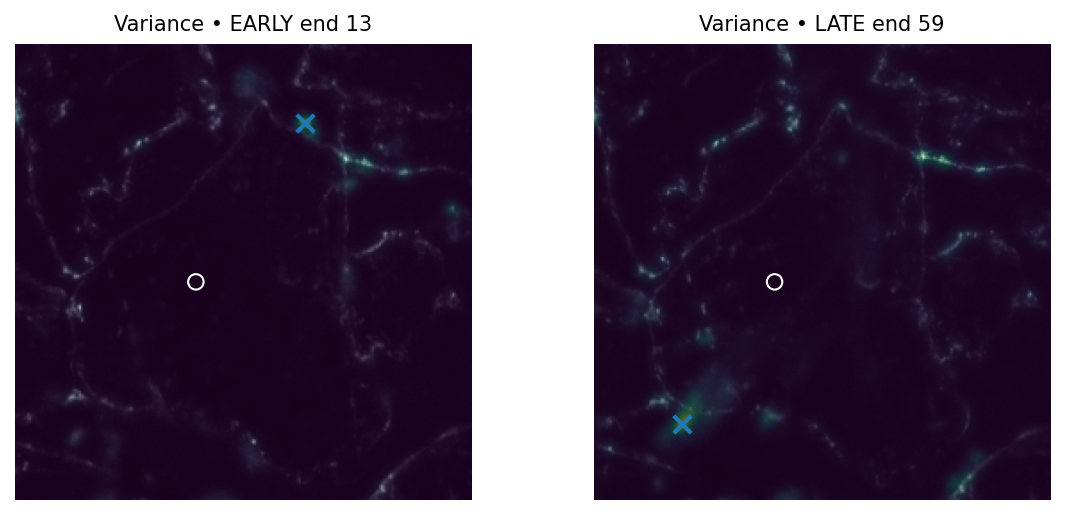

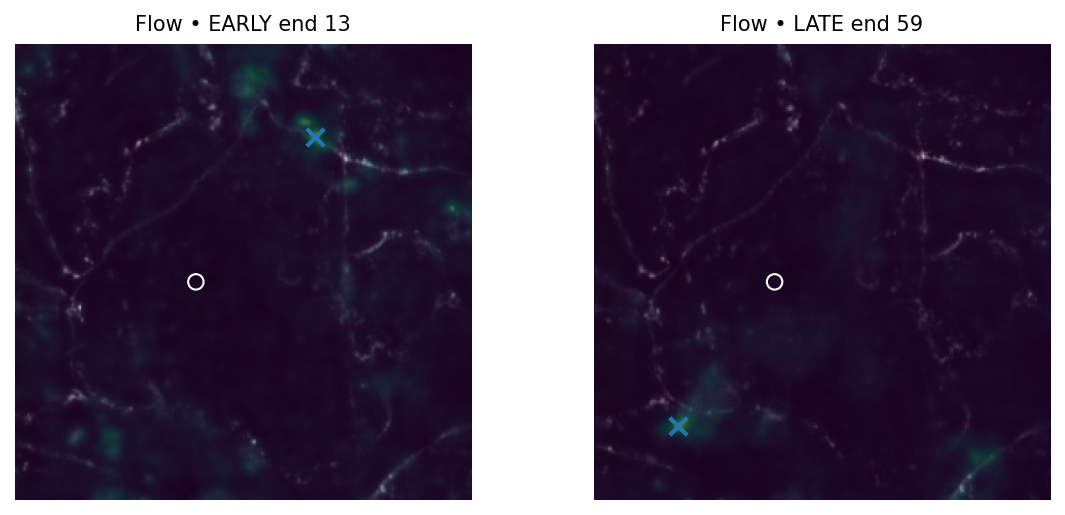

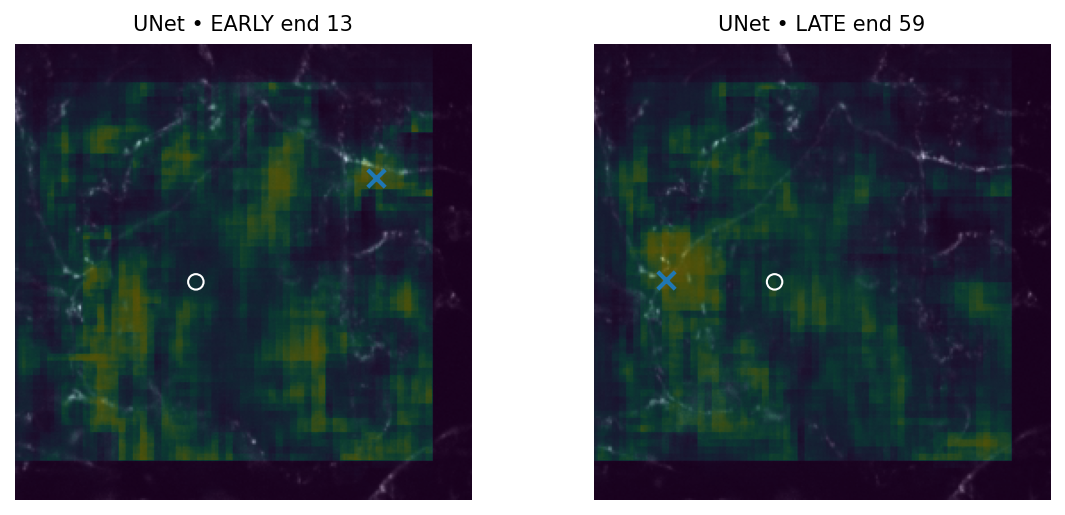

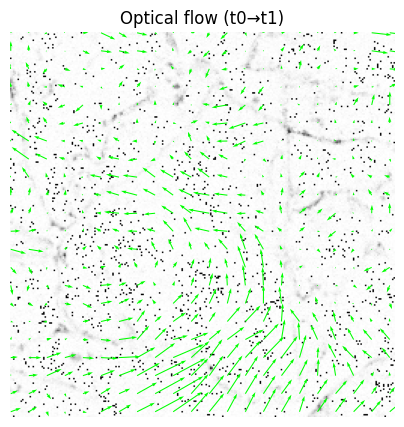

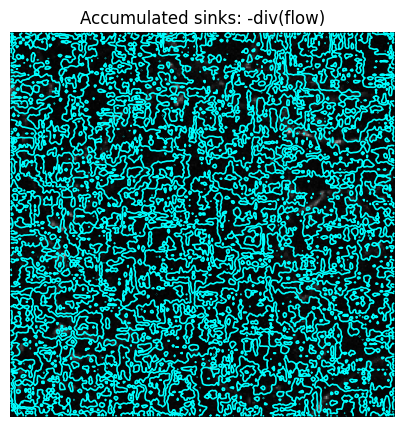

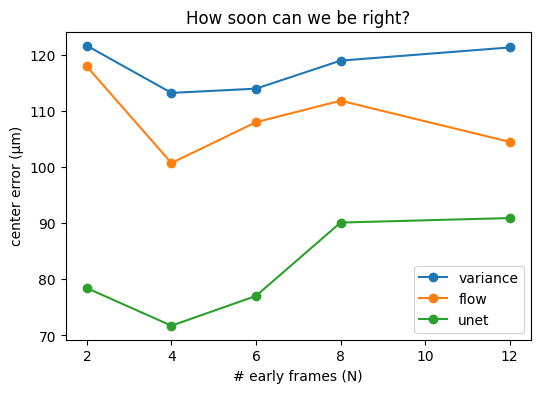


== Movie: 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr | T=400 | px=1.000 µm/px | GT label: True | t_agg=349
 UNet ep 01 | train 0.9971 | val 0.9647
 UNet ep 02 | train 0.9498 | val 0.9285
 UNet ep 03 | train 0.9229 | val 0.9118
 UNet ep 04 | train 0.9020 | val 0.8930
 UNet ep 05 | train 0.8865 | val 0.8900
 UNet ep 06 | train 0.8742 | val 0.8723
 UNet ep 07 | train 0.8647 | val 0.8645
 UNet ep 08 | train 0.8534 | val 0.8623
 UNet ep 09 | train 0.8549 | val 0.8410
 UNet ep 10 | train 0.8394 | val 0.8490
 UNet ep 11 | train 0.8380 | val 0.8416
 UNet ep 12 | train 0.8376 | val 0.8523
 UNet ep 13 | train 0.8342 | val 0.8359
 UNet ep 14 | train 0.8224 | val 0.8247
 UNet ep 15 | train 0.8247 | val 0.8396
 UNet ep 16 | train 0.8195 | val 0.8163
 UNet ep 17 | train 0.8105 | val 0.8232
 UNet ep 18 | train 0.8079 | val 0.8226
 UNet ep 19 | train 0.8118 | val 0.8328
 UNet ep 20 | train 0.8038 | val 0.8073
 UNet ep 21 | train 0.8004 | val 0.7943
 UNet ep 22 | train 0.7906 | val 0.777

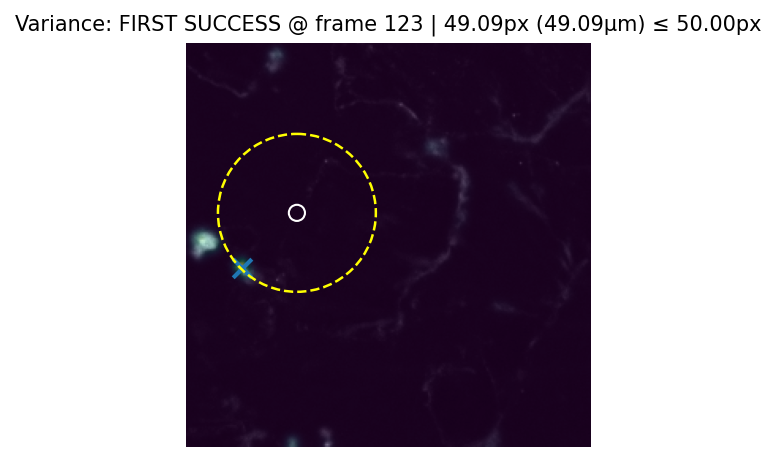

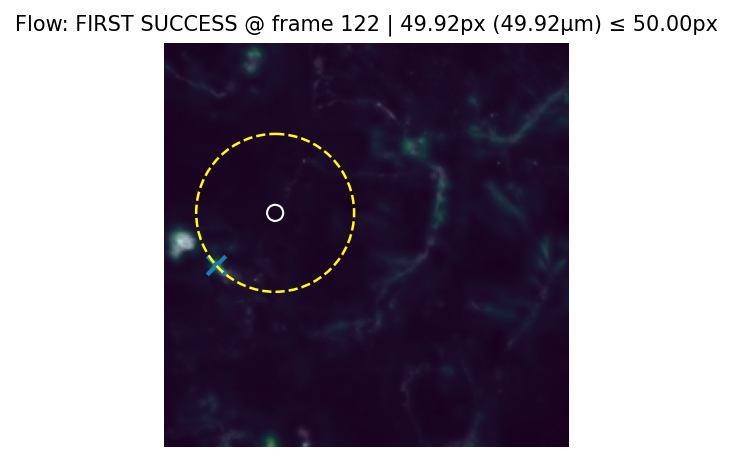

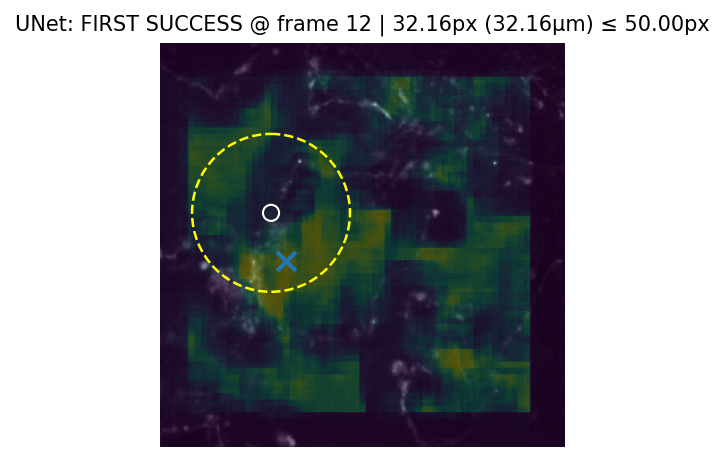

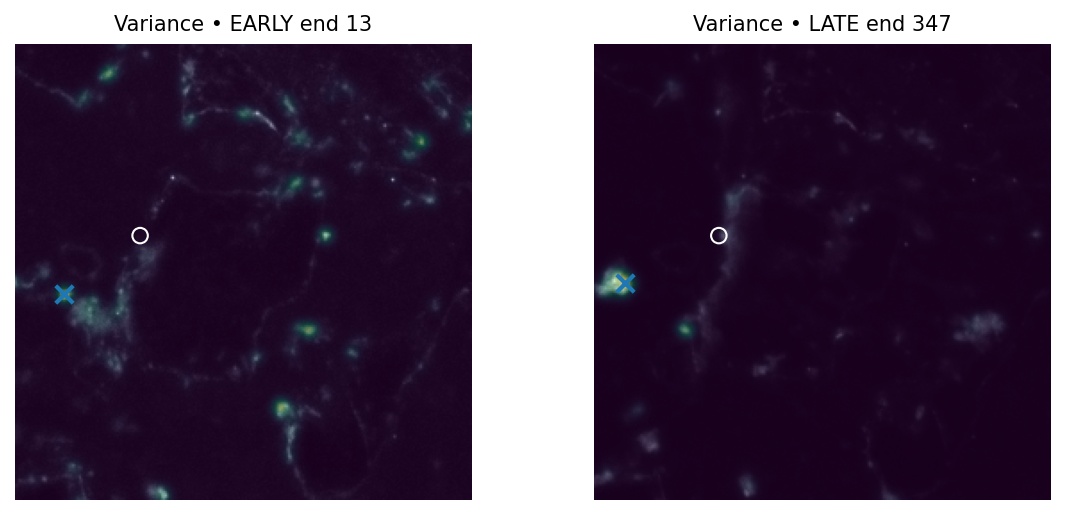

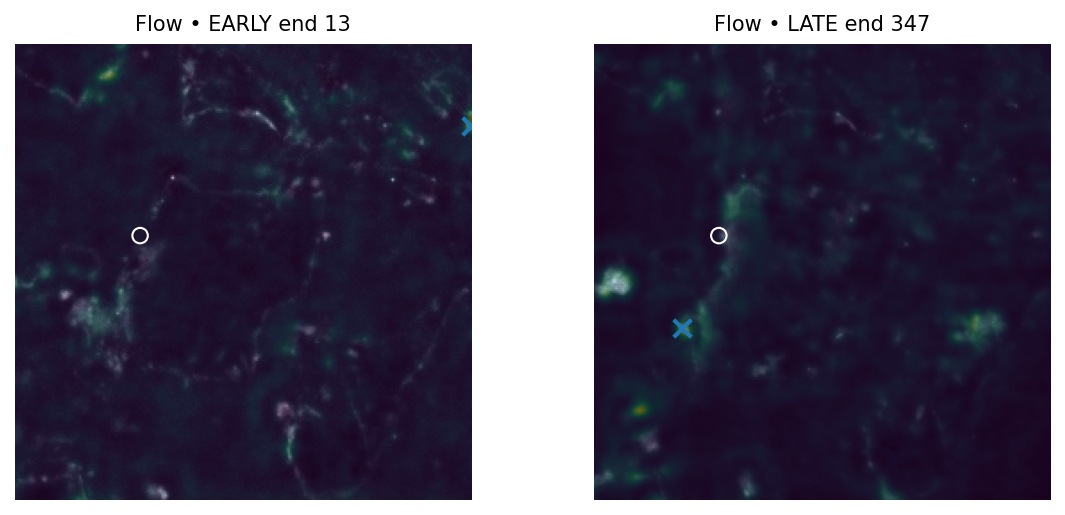

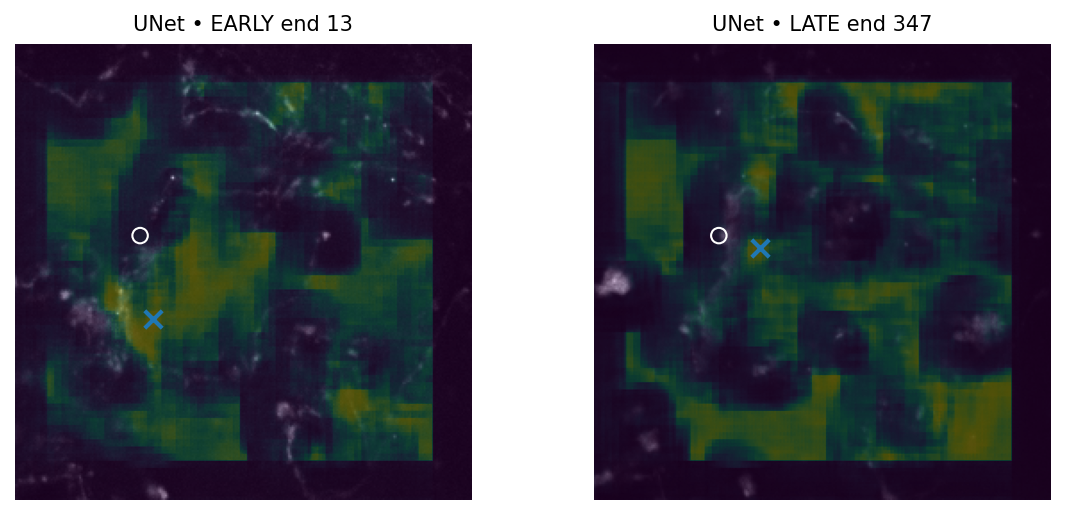

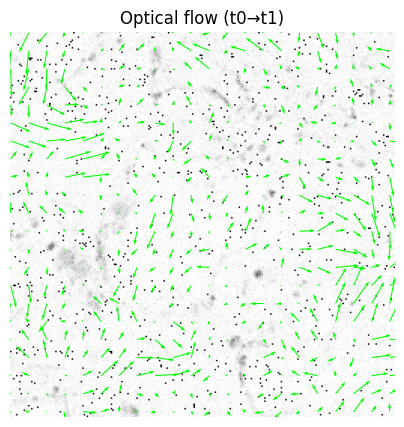

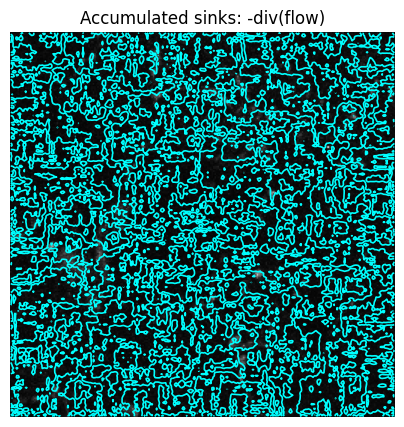

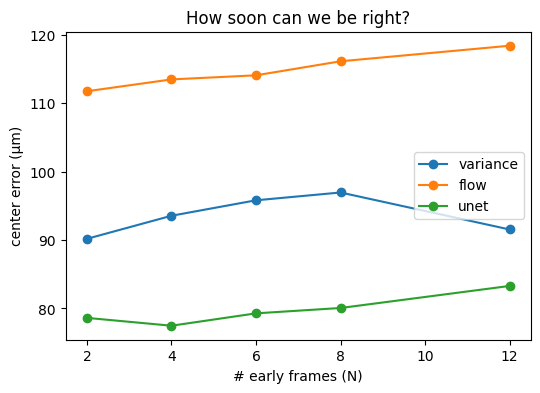


== Movie: ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr | T=200 | px=1.000 µm/px | GT label: True | t_agg=136
 UNet ep 01 | train 1.0594 | val 1.0287
 UNet ep 02 | train 1.0090 | val 0.9940
 UNet ep 03 | train 0.9849 | val 0.9786
 UNet ep 04 | train 0.9735 | val 0.9698
 UNet ep 05 | train 0.9749 | val 0.9691
 UNet ep 06 | train 0.9708 | val 0.9678
 UNet ep 07 | train 0.9673 | val 0.9656
 UNet ep 08 | train 0.9634 | val 0.9624
 UNet ep 09 | train 0.9624 | val 0.9613
 UNet ep 10 | train 0.9601 | val 0.9628
 UNet ep 11 | train 0.9589 | val 0.9523
 UNet ep 12 | train 0.9532 | val 0.9503
 UNet ep 13 | train 0.9464 | val 0.9414
 UNet ep 14 | train 0.9495 | val 0.9466
 UNet ep 15 | train 0.9413 | val 0.9451
 UNet ep 16 | train 0.9434 | val 0.9350
 UNet ep 17 | train 0.9365 | val 0.9402
 UNet ep 18 | train 0.9331 | val 0.9427
 UNet ep 19 | train 0.9314 | val 0.9263
 UNet ep 20 | train 0.9246 | val 0.9260
 UNet ep 21 | train 0.9226 | val 0.9235
 UNet ep 22 | train 0.9173 | 

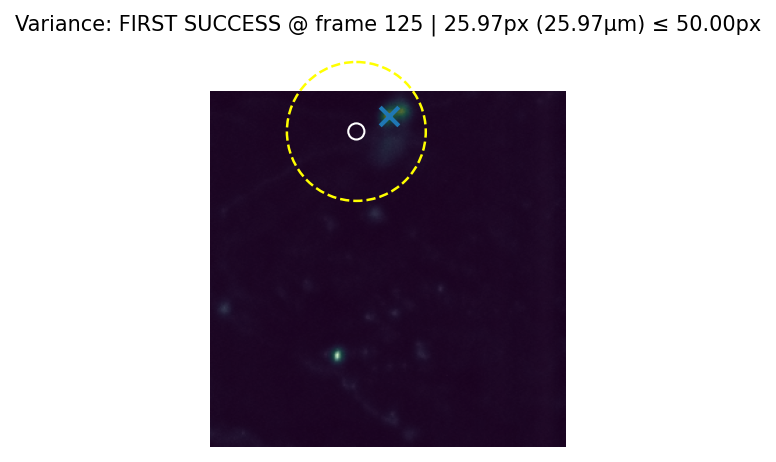

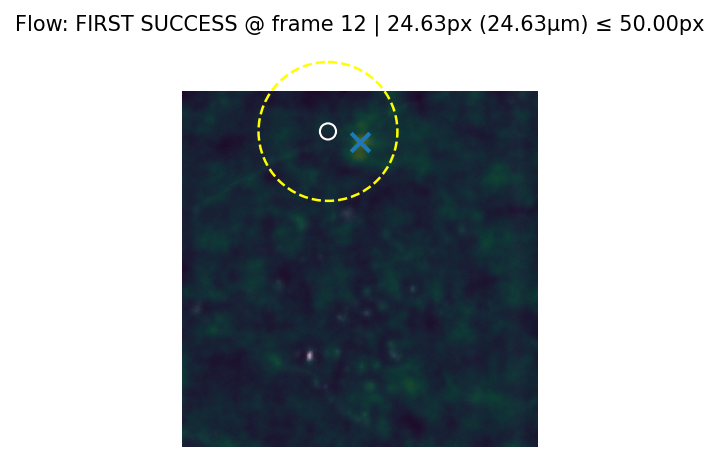

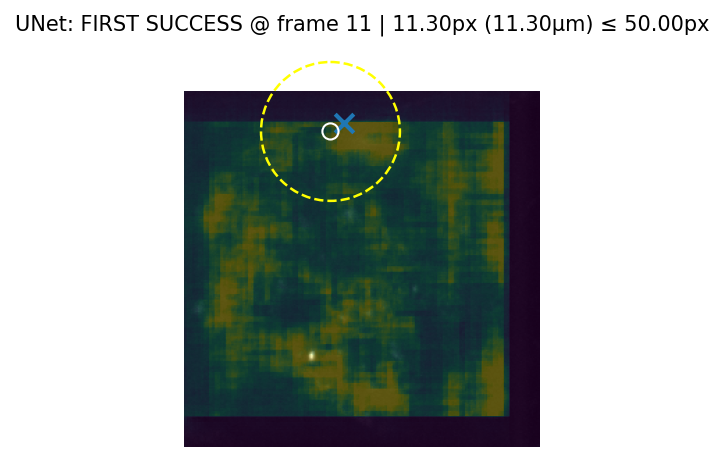

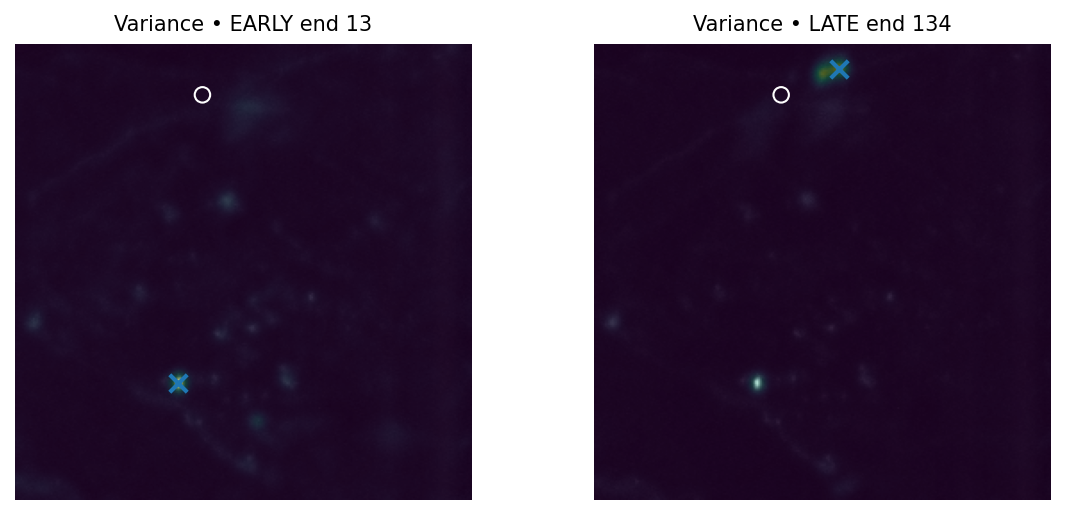

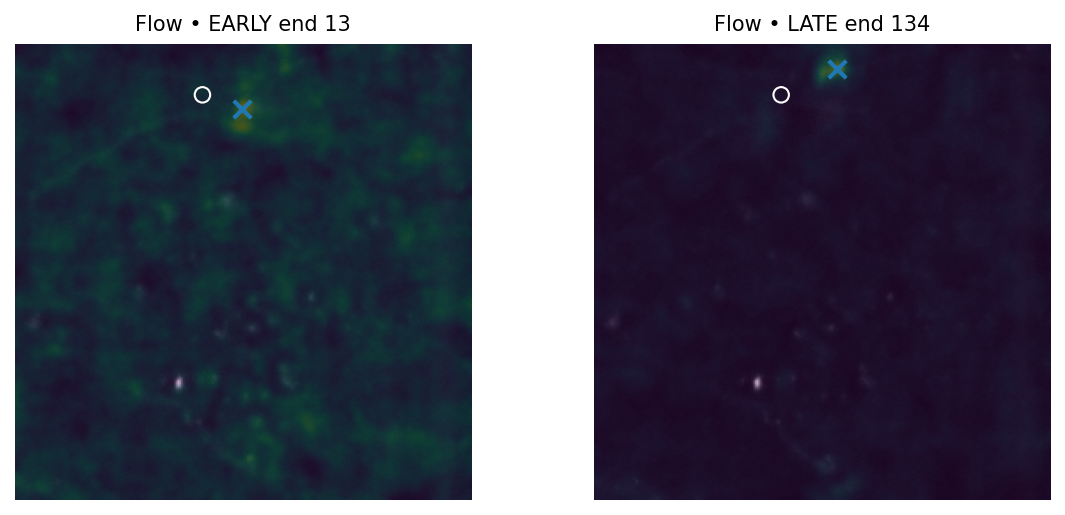

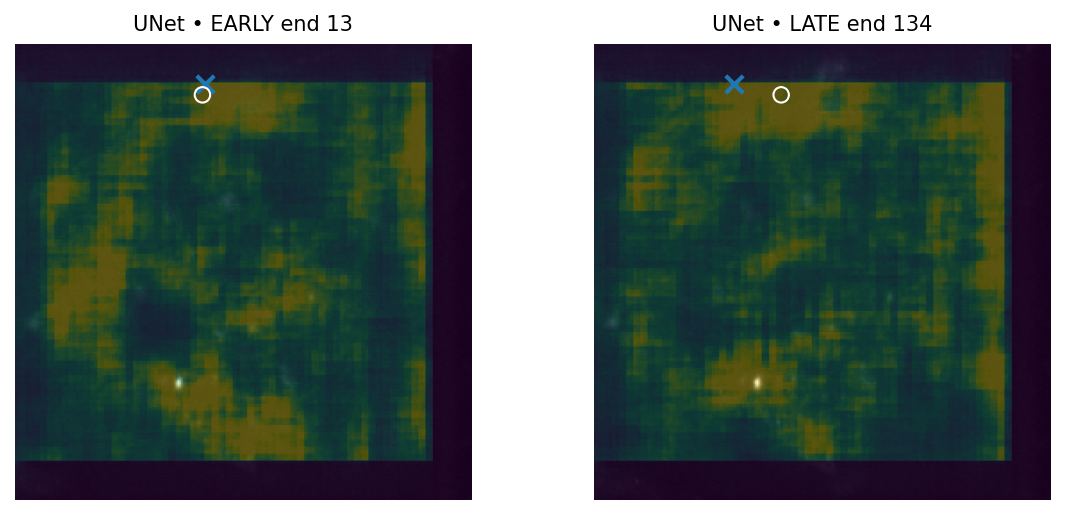

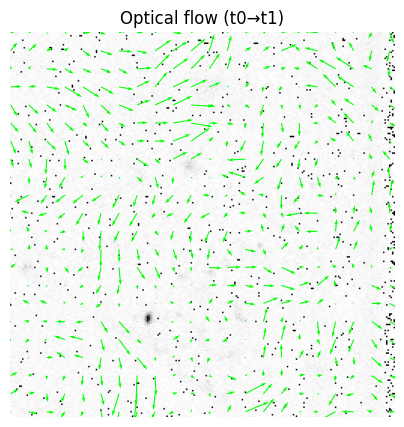

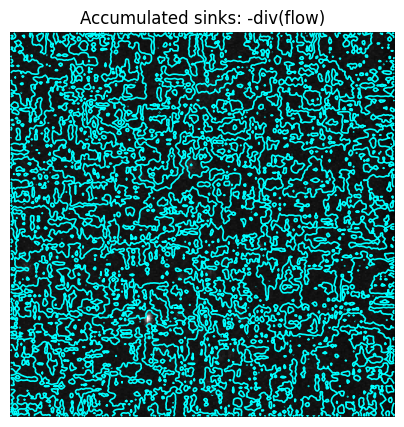

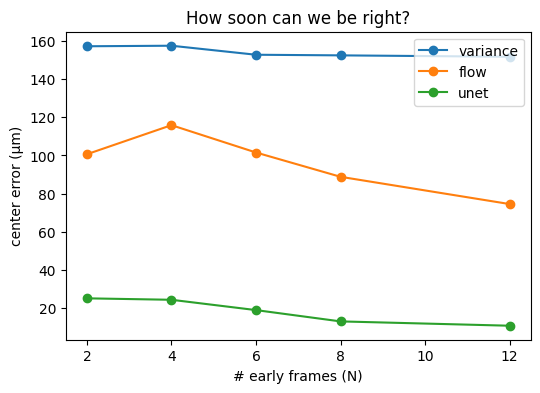

In [ ]:
def leave_one_out_eval(movie_paths, N=8, channel=0, z_strategy='mid', unet_epochs=15, preprocess=True, do_register=False):
    all_results=[]
    for i, test_path in enumerate(movie_paths):
        train_paths = [p for j,p in enumerate(movie_paths) if j!=i]
        res = evaluate_movie(
            test_path, N=N, channel=channel, z_strategy=z_strategy,
            train_movies_for_unet=train_paths, epochs=unet_epochs,
            preprocess=preprocess, do_register=do_register,
            radius_um_metrics=radius_um_metrics
        )
        all_results.append(res)
    return all_results

if len(MOVIES) == 1:
    print("WARNING: Only one movie — UNet disabled to avoid leakage; running baselines and metrics.")
    results = [evaluate_movie(MOVIES[0], N=N, channel=channel, z_strategy=z_strategy,
                              train_movies_for_unet=[], epochs=unet_epochs,
                              preprocess=preprocess, do_register=do_register,
                              radius_um_metrics=radius_um_metrics)]
else:
    results = leave_one_out_eval(MOVIES, N=N, channel=channel, z_strategy=z_strategy,
                                 unet_epochs=unet_epochs, preprocess=preprocess, do_register=do_register)

**14) Report**

In [ ]:
def mean_ci(vals, n_boot=1000, ci=95):
    vals = np.array(vals, float); arr = vals[~np.isnan(vals)]
    if len(arr)==0: return (float('nan'), float('nan'), float('nan'))
    boots=[np.mean(np.random.choice(arr, size=len(arr), replace=True)) for _ in range(n_boot)]
    lo,hi = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])
    return float(np.mean(arr)), float(lo), float(hi)

def fmt_ci(mu, lo, hi, digits=3): return f"{mu:.{digits}f} ± [{lo:.{digits}f}, {hi:.{digits}f}]"

rows=[]
for r in results:
    mv=r["movie"]
    for model in ["variance","flow","unet"]:
        ms=r["movie_stats"][model]
        rows.append([mv, model,
                     fmt_ci(ms["center_err_um_mean"], *ms["center_err_um_CI"]),
                     fmt_ci(ms["AUROC_mean"], *ms["AUROC_CI"]),
                     fmt_ci(ms["AP_mean"], *ms["AP_CI"])])

df_summary = pd.DataFrame(rows, columns=["Movie","Model","Center err (µm) mean±CI","AUROC mean±CI","AP mean±CI"])
print("\n===== Results per movie =====")
print(tabulate(df_summary, headers='keys', tablefmt='github', showindex=False))
df_summary.to_csv(os.path.join(ART_DIR, "per_movie.csv"), index=False)

# Overall aggregates
agg={"variance":{"err":[],"roc":[],"ap":[]}, "flow":{"err":[],"roc":[],"ap":[]}, "unet":{"err":[],"roc":[],"ap":[]}}
for r in results:
    for m in ["variance","flow","unet"]:
        agg[m]["err"].extend(r["per_window_errs_um"][m])
        agg[m]["roc"].extend(r["per_window_auroc"][m])
        agg[m]["ap"].extend(r["per_window_ap"][m])

rows2=[]
for m in ["variance","flow","unet"]:
    mu1,lo1,hi1 = mean_ci(np.array(agg[m]["err"],float))
    mu2,lo2,hi2 = mean_ci(np.array(agg[m]["roc"],float))
    mu3,lo3,hi3 = mean_ci(np.array(agg[m]["ap"],float))
    rows2.append([m, fmt_ci(mu1,lo1,hi1), fmt_ci(mu2,lo2,hi2), fmt_ci(mu3,lo3,hi3)])

df_overall = pd.DataFrame(rows2, columns=["Model", "Center err (µm) mean±CI", "AUROC mean±CI", "AP mean±CI"])
print("\n===== Overall (across all movies & windows) =====")
print(tabulate(df_overall, headers='keys', tablefmt='github', showindex=False))
df_overall.to_csv(os.path.join(ART_DIR, "overall.csv"), index=False)

# First-success minutes (per movie)
rowsFS=[]
for r in results:
    mv=r["movie"]; fsm=r.get("first_success_min",{})
    rowsFS.append([mv, fsm.get("variance","n/a"), fsm.get("flow","n/a"), fsm.get("unet","n/a")])
df_first_success = pd.DataFrame(rowsFS, columns=["Movie","First success (min) - Variance","First success (min) - Flow","First success (min) - UNet"])
print("\n===== First-success time (minutes) =====")
print(tabulate(df_first_success, headers='keys', tablefmt='github', showindex=False))
df_first_success.to_csv(os.path.join(ART_DIR, "first_success_minutes.csv"), index=False)

print(f"\n[artifacts] saved to: {os.path.abspath(ART_DIR)}")


===== Results per movie =====
| Movie                                                             | Model    | Center err (µm) mean±CI      | AUROC mean±CI          | AP mean±CI             |
|-------------------------------------------------------------------|----------|------------------------------|------------------------|------------------------|
| 2024-01-17_ERH_23hr_ERH Red FarRed.zarr                           | variance | 120.472 ± [115.395, 125.373] | 0.208 ± [0.185, 0.233] | 0.072 ± [0.070, 0.075] |
| 2024-01-17_ERH_23hr_ERH Red FarRed.zarr                           | flow     | 107.585 ± [105.003, 110.131] | 0.314 ± [0.289, 0.345] | 0.085 ± [0.080, 0.091] |
| 2024-01-17_ERH_23hr_ERH Red FarRed.zarr                           | unet     | 86.100 ± [78.092, 93.586]    | 0.710 ± [0.699, 0.722] | 0.187 ± [0.177, 0.198] |
| 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr          | variance | 91.784 ± [87.900, 95.534]    | 0.435 ± [0.429, 0.441] | 0.107 ± [0.105, 0.109]

**Final model ranking: accuracy and robustness**

In [ ]:
import numpy as np, pandas as pd
from tabulate import tabulate

# Accuracy rank: lower mean center error (µm) is better
acc_rows = []
for m in ["Variance (baseline)", "Flow Convergence (baseline)", "Tiny U-Net (learned)"]:
    # fallback to old keys if needed
    key = m if m in results[0]["movie_stats"] else {"Variance (baseline)":"variance","Flow Convergence (baseline)":"flow","Tiny U-Net (learned)":"unet"}[m]
    mu = np.nanmean([r["movie_stats"][key]["center_err_um_mean"] for r in results])
    acc_rows.append([m, mu])
df_acc = pd.DataFrame(acc_rows, columns=["Model","Mean center error (µm)"]).sort_values("Mean center error (µm)")
print("\n===== Ranking by spatial accuracy (lower is better) =====")
print(tabulate(df_acc, headers='keys', tablefmt='github', showindex=False))

# Robustness rank: lower mean relative drop (%) across scales is better
rob_rows = []
for m in ["variance","flow","unet"]:
    drops=[]
    for r in results:
        for (model, sc, base, drop) in r["robust_rows"]:
            if model==m: drops.append(drop)
    if drops:
        rob_rows.append([{"variance":"Variance (baseline)","flow":"Flow Convergence (baseline)","unet":"Tiny U-Net (learned)"}[m],
                         float(np.nanmean(drops))])
df_rob = pd.DataFrame(rob_rows, columns=["Model","Mean relative drop (%)"]).sort_values("Mean relative drop (%)")
print("\n===== Ranking by robustness (lower drop is better) =====")
print(tabulate(df_rob, headers='keys', tablefmt='github', showindex=False))


===== Ranking by spatial accuracy (lower is better) =====
| Model                       |   Mean center error (µm) |
|-----------------------------|--------------------------|
| Tiny U-Net (learned)        |                  61.0465 |
| Flow Convergence (baseline) |                  98.5469 |
| Variance (baseline)         |                 121.048  |

===== Ranking by robustness (lower drop is better) =====
| Model                       |   Mean relative drop (%) |
|-----------------------------|--------------------------|
| Variance (baseline)         |                -0.519271 |
| Flow Convergence (baseline) |                85.0143   |
| Tiny U-Net (learned)        |               133.239    |


**Bonus A: Multi-center handling (Top-K peaks + hit-rate metrics)**

In [ ]:

from typing import Optional, Tuple, List, Dict

# Utility: Top-K distance and peaks (used in multi-center metrics)
from scipy.ndimage import maximum_filter

def center_error_topk_um(
    prob_map: np.ndarray,
    true_xy: Tuple[float, float],
    px_um: float,
    k: int = 3
) -> Tuple[float, List[Tuple[float, float]]]:
    """
    Compute the min Euclidean distance (µm) between GT and the Top-K
    peaks in a probability map.

    Returns:
        (min_dist_um, [(x,y) of top-K peaks])
    """
    H, W = prob_map.shape
    # --- Find Top-K local maxima robustly ---
    footprint = np.ones((3, 3))
    local_max = (prob_map == maximum_filter(prob_map, footprint=footprint))
    peak_coords = np.argwhere(local_max)

    if peak_coords.size == 0:
        # fallback to global maximum
        yy, xx = np.unravel_index(np.argmax(prob_map), prob_map.shape)
        peaks = [(float(xx), float(yy))]
    else:
        # sort by probability descending
        vals = [prob_map[y, x] for y, x in peak_coords]
        order = np.argsort(vals)[::-1][:k]
        peaks = [(float(peak_coords[i,1]), float(peak_coords[i,0])) for i in order]

    # compute distances to GT
    gx, gy = true_xy
    dists_um = [np.sqrt((gx - x)**2 + (gy - y)**2) * px_um for (x, y) in peaks]
    min_dist_um = float(np.min(dists_um)) if len(dists_um) > 0 else float("inf")

    return min_dist_um, peaks

def _load_unet_checkpoint_or_none(N: int, ckpt_path: Optional[str] = None) -> Optional[nn.Module]:
    """
    Try to load TinyUNet(N) from a checkpoint; return None if not found.
    """
    path = ckpt_path or os.path.join(ART_DIR, f"unet_{N}ch_best.pt")
    if not os.path.exists(path):
        print(f"[multi-center] No UNet checkpoint at {path}. Will skip UNet in Top-K metrics.")
        return None
    model = TinyUNet(N).to(DEVICE)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    print(f"[multi-center] Loaded UNet from {path}")
    return model

@torch.no_grad()
def _predict_unet_map_from_model(model: nn.Module, x_np: np.ndarray) -> Tuple[Tuple[float,float], np.ndarray]:
    """
    Wrapper using the same inference path as the main pipeline.
    """
    return predict_unet_map(model, x_np)  # -> (center_xy, heatmap in [0,1])

def _hit_within_radius_um(
    prob_map: np.ndarray,
    true_xy: Tuple[float,float],
    px_um: float,
    k: int,
    radius_um: float
) -> Tuple[bool, float, List[Tuple[float,float]]]:
    """
    Return (hit:bool, min_dist_um:float, peaks:list[(x,y)]).
    'hit' if any Top-K peak is within radius_um of GT.
    """
    d_um, peaks = center_error_topk_um(prob_map, true_xy, px_um, k=k)
    return (d_um <= radius_um), d_um, peaks

def multicenter_metrics_for_movie(
    movie_path: str,
    N: int = 8,
    channel: int = 0,
    z_strategy: str = "mid",
    k: int = 3,
    radius_um: float = RADIUS_UM_DEFAULT,
    sample_windows: int = 20,
    preprocess: bool = False,
    do_register: bool = False,
    save_csv: bool = True,
    model: Optional[nn.Module] = None,       # optional in-memory model (no GLOBALS)
    ckpt_path: Optional[str] = None,         # or load from checkpoint if provided
) -> pd.DataFrame:
    """
    Compute Top-K 'hit-rate' (% of sampled windows with a peak within radius_um of GT)
    for Variance, Flow, and UNet (if a model is provided or a checkpoint is found).
    Saves a per-movie CSV and prints a summary.
    """
    # Load movie & GT
    arr = read_zarr_any(movie_path)
    px_um = get_pixel_size_um(arr) or 1.0
    (gt_cx, gt_cy), _, t_agg, _, _ = make_gt_for_movie(arr, movie_path, channel, z_strategy)
    gt_xy = (gt_cx, gt_cy)

    #Build dataset (prefer early, pre-aggregation windows)
    ds = EarlyWindow(
        arr, N=N, channel=channel, z_strategy=z_strategy,
        preprocess=preprocess, do_register=do_register, t_agg=t_agg
    )
    if len(ds) == 0:
        ds = EarlyWindow(
            arr, N=N, channel=channel, z_strategy=z_strategy,
            preprocess=preprocess, do_register=do_register, t_agg=None
        )
    if len(ds) == 0:
        raise RuntimeError("No windows found for multi-center evaluation.")

    # Evenly sample windows
    idxs = np.linspace(0, len(ds)-1, num=min(sample_windows, len(ds)), dtype=int).tolist()

    # Decide UNet source: use provided model, else try to load from ckpt
    unet_model: Optional[nn.Module] = model if model is not None else _load_unet_checkpoint_or_none(N, ckpt_path)

    #Accumulators
    rows: List[List[object]] = []
    hits: Dict[str, int] = {"variance": 0, "flow": 0, "unet": 0}
    dists: Dict[str, List[float]] = {"variance": [], "flow": [], "unet": []}

    #Evaluate per sampled window
    for i in idxs:
        xN = ds[i].numpy()  # [N,H,W]

        # Variance (torch baseline)
        _, vmap = variance_hotspot_torch(xN)
        h, d, peaks = _hit_within_radius_um(vmap, gt_xy, px_um, k, radius_um)
        hits["variance"] += int(h); dists["variance"].append(d)
        rows.append(["variance", i, d, h, peaks])

        # Flow convergence (torch + opencv baseline)
        _, fmap = flow_convergence_hotspot_torch(xN)
        h, d, peaks = _hit_within_radius_um(fmap, gt_xy, px_um, k, radius_um)
        hits["flow"] += int(h); dists["flow"].append(d)
        rows.append(["flow", i, d, h, peaks])

        # UNet (optional, only if model available)
        if unet_model is not None:
            _, umap = _predict_unet_map_from_model(unet_model, xN)
            h, d, peaks = _hit_within_radius_um(umap, gt_xy, px_um, k, radius_um)
            hits["unet"] += int(h); dists["unet"].append(d)
            rows.append(["unet", i, d, h, peaks])

    # Save CSV ----
    mvname = os.path.splitext(os.path.basename(movie_path))[0].replace('.zarr','')
    df = pd.DataFrame(rows, columns=["model","window_idx","min_dist_um","hit_within_radius","topk_peaks_xy"])
    if save_csv:
        out = os.path.join(ART_DIR, f"{mvname}_multicenter_top{k}_radius{int(radius_um)}um.csv")
        df.to_csv(out, index=False)
        print(f"[saved] {out}")

    # Console summary
    print("\n=== Multi-center Top-K summary ===")
    total = len(idxs)
    label_map = {"variance":"Variance (baseline)", "flow":"Flow Convergence (baseline)", "unet":"Tiny U-Net (learned)"}
    for key in ["variance", "flow", "unet"]:
        if len(dists[key]) == 0:  # UNet may be missing
            continue
        rate = 100.0 * hits[key] / total
        mu = float(np.mean(dists[key])); lo, hi = np.percentile(dists[key], [2.5, 97.5])
        print(f"{label_map[key]:26s} | hit-rate: {rate:5.1f}%  | min-dist (µm): mean {mu:.2f}  CI [{lo:.2f}, {hi:.2f}]")

    return df

# Run multi-center Top-K evaluation for each movie
if 'MOVIES' in globals():
    for p in MOVIES:
        multicenter_metrics_for_movie(
            p, N=8, k=3, radius_um=RADIUS_UM_DEFAULT,
            preprocess=True, do_register=False,
            model=None,            # pass a trained TinyUNet(N) if you already have it in memory
            ckpt_path=None         # or set a custom checkpoint path; else defaults to artifacts/unet_{N}ch_best.pt
        )


[multi-center] No UNet checkpoint at ./artifacts/unet_8ch_best.pt. Will skip UNet in Top-K metrics.
[saved] ./artifacts/2024-01-17_ERH_23hr_ERH Red FarRed_multicenter_top3_radius25um.csv

=== Multi-center Top-K summary ===
Variance (baseline)        | hit-rate:   0.0%  | min-dist (µm): mean 101.78  CI [83.85, 111.90]
Flow Convergence (baseline) | hit-rate:   0.0%  | min-dist (µm): mean 97.96  CI [70.63, 114.84]
[multi-center] No UNet checkpoint at ./artifacts/unet_8ch_best.pt. Will skip UNet in Top-K metrics.
[saved] ./artifacts/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_multicenter_top3_radius25um.csv

=== Multi-center Top-K summary ===
Variance (baseline)        | hit-rate:   0.0%  | min-dist (µm): mean 65.96  CI [48.54, 97.15]
Flow Convergence (baseline) | hit-rate:   5.0%  | min-dist (µm): mean 75.36  CI [27.21, 130.37]
[multi-center] No UNet checkpoint at ./artifacts/unet_8ch_best.pt. Will skip UNet in Top-K metrics.
[saved] ./artifacts/ERH_2024-04-04_mixin64_wellC5_10x_o

**Bonus B — Uncertainty maps (MC-Dropout if present, else TTA ensemble)**

[uncertainty] Loaded UNet from ./artifacts/unet_4ch_best.pt
[uncertainty] No dropout layers found → using TTA ensemble.


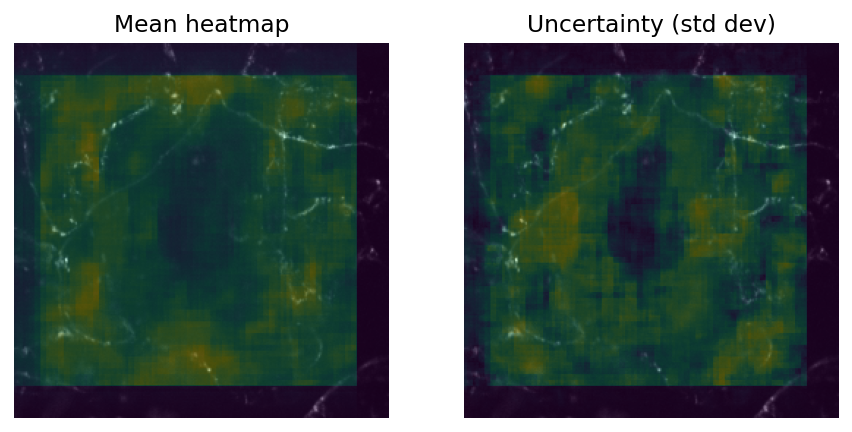

[saved] 2024-01-17_ERH_23hr_ERH Red FarRed_w25_N12_uncert_(mean|std).npy and figure in ./artifacts
[uncertainty] No dropout layers found → using TTA ensemble.


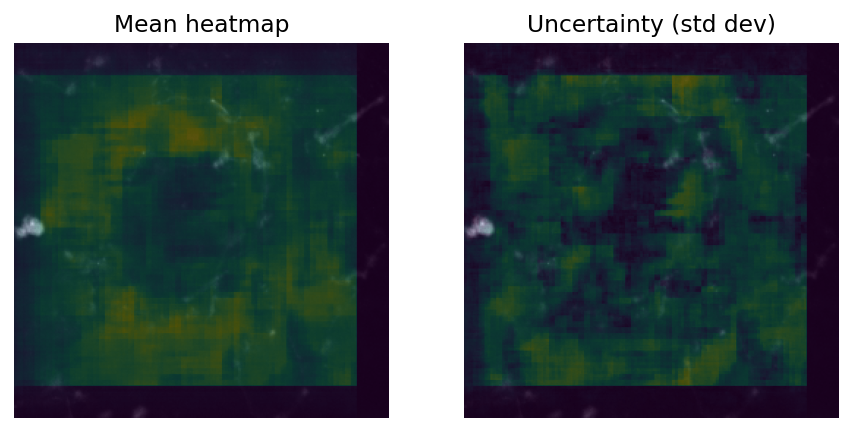

[saved] 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_w169_N12_uncert_(mean|std).npy and figure in ./artifacts
[uncertainty] No dropout layers found → using TTA ensemble.


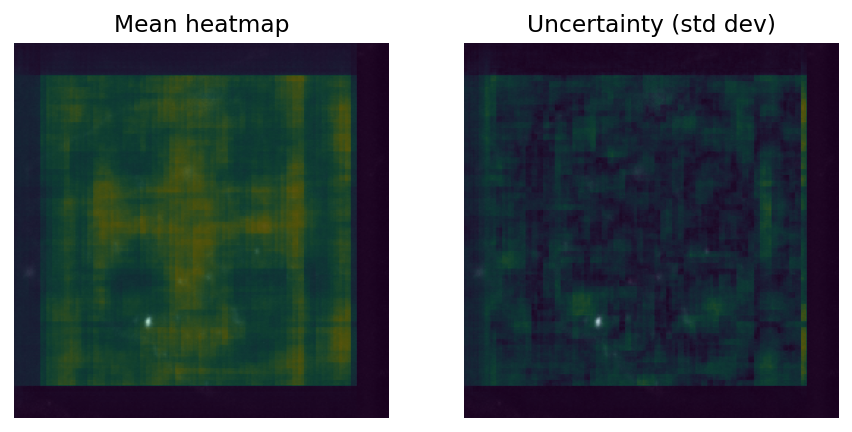

[saved] ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_w62_N12_uncert_(mean|std).npy and figure in ./artifacts


In [ ]:
"""**Bonus B — Uncertainty maps (MC-Dropout if present, else TTA ensemble)**"""

from typing import Optional, Dict, List

def _enable_mc_dropout(module: nn.Module) -> int:
    """Put all Dropout layers into training mode for MC sampling; return count."""
    count = 0
    for m in module.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            m.train()
            count += 1
    return count


def _tta_augment_window(x_np: np.ndarray) -> np.ndarray:
    """Lightweight, label-preserving augmentation across the temporal stack [N,H,W]."""
    x = x_np.copy()
    # flips on H/W
    if np.random.rand() < 0.5:
        x = x[:, :, ::-1]   # horiz flip (W)
    if np.random.rand() < 0.5:
        x = x[:, ::-1, :]   # vert flip (H)
    # simple intensity jitter
    s = 1.0 + 0.15 * (np.random.rand() - 0.5)  # contrast
    b = 0.10 * (np.random.rand() - 0.5)        # brightness
    x = np.clip(x * s + b, -5, 5)
    return x


@torch.no_grad()
def stochastic_heatmaps_window(
    model: nn.Module,
    x_window_np: np.ndarray,            # [N,H,W] early window (same as everywhere else)
    T: int = 20,
    prefer_mc_dropout: bool = True,
    save_prefix: Optional[str] = None
) -> Dict[str, np.ndarray]:

    model = model.to(DEVICE)
    model.eval()

    used_mc = False
    n_drop = 0
    if prefer_mc_dropout:
        n_drop = _enable_mc_dropout(model)  # activate only dropout layers
        used_mc = n_drop > 0
        if used_mc:
            print(f"[uncertainty] MC-dropout enabled with {n_drop} dropout layer(s).")
        else:
            print("[uncertainty] No dropout layers found → using TTA ensemble.")

    samples: List[np.ndarray] = []
    for _ in range(max(1, int(T))):
        # TTA works on [N,H,W]; MC-dropout uses the raw window
        x_in = x_window_np if used_mc else _tta_augment_window(x_window_np)

        # Convert to 4-channel motion feature stack [4,H,W]
        feat = make_model_input(x_in)              # <--- your existing helper
        x = feat.unsqueeze(0).to(DEVICE).float()   # [1,4,H,W]

        # UNet forward → normalize to [0,1]
        y = model(x).sigmoid().squeeze(0).squeeze(0).detach().cpu().numpy()
        y = (y - y.min()) / (y.max() - y.min() + 1e-8)
        samples.append(y.astype(np.float32))

    stack = np.stack(samples, axis=0)      # [T,H,W]
    mu = stack.mean(0)                     # [H,W]
    sd = stack.std(0)                      # [H,W]

    # Normalize for overlays
    mu_n = (mu - mu.min()) / (mu.max() - mu.min() + 1e-8)
    sd_n = (sd - sd.min()) / (sd.max() - sd.min() + 1e-8)

    if save_prefix is not None:
        np.save(os.path.join(ART_DIR, f"{save_prefix}_uncert_mean.npy"), mu)
        np.save(os.path.join(ART_DIR, f"{save_prefix}_uncert_std.npy"), sd)

        # quick visuals
        fig, ax = plt.subplots(1, 2, figsize=(7.6, 3.6), dpi=140)
        ax[0].imshow(x_window_np.mean(0), cmap='gray'); ax[0].imshow(mu_n, alpha=0.35)
        ax[0].set_title("Mean heatmap"); ax[0].axis('off')
        ax[1].imshow(x_window_np.mean(0), cmap='gray'); ax[1].imshow(sd_n, alpha=0.35)
        ax[1].set_title("Uncertainty (std dev)"); ax[1].axis('off')
        fig.savefig(os.path.join(ART_DIR, f"{save_prefix}_uncert_fig.png"),
                    dpi=220, bbox_inches='tight')
        plt.show()

    return {
        "mean": mu, "std": sd,
        "mean_norm": mu_n, "std_norm": sd_n,
        "used_mc_dropout": used_mc, "n_dropout": n_drop
    }


def _load_unet_for_uncertainty(ckpt_path: Optional[str] = None) -> Optional[nn.Module]:
    """
    Load the trained TinyUNet used in the main pipeline.

    We know we trained a 4-channel UNet and saved it as 'unet_4ch_best.pt'
    inside ART_DIR in train_unet_from_dataset(...).
    """
    # Default to the 4-channel checkpoint
    path = ckpt_path or os.path.join(ART_DIR, "unet_4ch_best.pt")
    if not os.path.exists(path):
        print(f"[uncertainty] No UNet checkpoint at {path}.")
        print("  → Either pass a trained model=... or run the UNet training cell first.")
        return None

    net = TinyUNet(in_ch=4).to(DEVICE)
    net.load_state_dict(torch.load(path, map_location=DEVICE))
    net.eval()
    print(f"[uncertainty] Loaded UNet from {path}")
    return net


@torch.no_grad()
def export_uncertainty_for_movies(
    movies: List[str],
    N: int = 12,                # number of early frames per window (match your main N)
    channel: int = 0,
    z_strategy: str = "mid",
    T: int = 20,
    preprocess: bool = True,
    do_register: bool = False,
    model: Optional[nn.Module] = None,
    ckpt_path: Optional[str] = None,
):
    """
    For each movie:
      * pick one representative early window (midpoint of EarlyWindow),
      * run stochastic sampling to get mean/std UNet heatmaps,
      * save .npy + a 2-panel figure.
    """
    # Pick a model: either the one provided or load from disk
    net = model if model is not None else _load_unet_for_uncertainty(ckpt_path)
    if net is None:
        return

    for mp in movies:
        arr = read_zarr_any(mp)
        (_, _), _, t_agg, _, _ = make_gt_for_movie(arr, mp, channel, z_strategy)

        ds = EarlyWindow(
            arr, N=N, channel=channel, z_strategy=z_strategy,
            preprocess=preprocess, do_register=do_register, t_agg=t_agg
        )
        if len(ds) == 0:
            ds = EarlyWindow(
                arr, N=N, channel=channel, z_strategy=z_strategy,
                preprocess=preprocess, do_register=do_register, t_agg=None
            )
        if len(ds) == 0:
            print(f"[uncertainty] No windows for {mp}")
            continue

        # Representative mid window
        widx = len(ds) // 2
        xN = ds[widx].numpy()  # [N,H,W]

        tag = os.path.splitext(os.path.basename(mp))[0].replace('.zarr', '')
        out_prefix = f"{tag}_w{widx}_N{N}"
        _ = stochastic_heatmaps_window(
            net, xN, T=T, prefer_mc_dropout=True, save_prefix=out_prefix
        )
        print(f"[saved] {out_prefix}_uncert_(mean|std).npy and figure in {ART_DIR}")


# Run uncertainty export
if 'MOVIES' in globals() and len(MOVIES) > 0:
    export_uncertainty_for_movies(
        MOVIES,
        N=N,
        T=20,
        preprocess=True,
        do_register=False,
        model=None,
        ckpt_path=None     # or override with a custom path
    )
